# Predicting Palmera Chocolate

We are going now to examine and treat our first series: palmera de chocolate.
    
Along this script we will:
    
    1) Paint the series, examine its autocorrelations and seasonality and get some useful insights.
    2) Apply different kinds of models to it, particularly time series models and machine learning models, also, when neuronal networks will be considered.
    3) Check the results we get from each method and extract our conclusions

# 1) Introductory examination

We import the required packages and our dataframe, and extract from it our series.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing tools from statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa as tsa
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools as stto

from datetime import timedelta

plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# train-test split library
from sklearn.model_selection import train_test_split

import random

# ERRORS
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import performance_metrics

# EXPONENTIAL SMOOTHING
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

#PROPHET
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 5

In [3]:
sep=";"
exit_path = "../../data/03_processed/" + "time_series.csv"

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [5]:
df=pd.read_csv(exit_path, sep=sep, parse_dates=True, index_col='order_date')

In [6]:
palmera_choco=df[df['product']=='palmera chocolate'][['units_ordered','festivo','weight']]

Now, we check our series, by plotting it and getting its first statistical values:

### 1.1) Series plot and first values

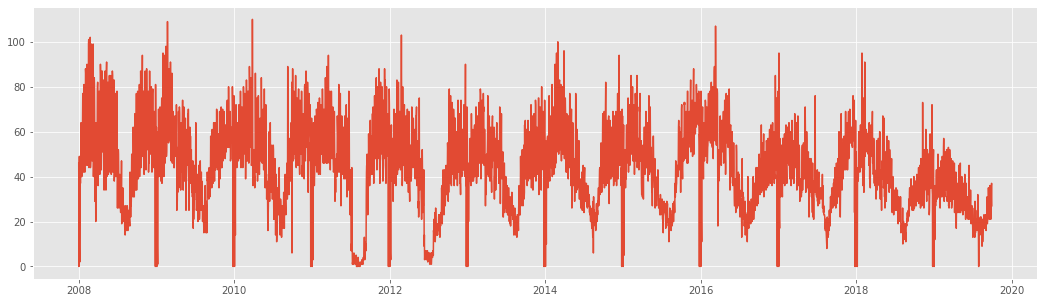

In [7]:
plt.plot(palmera_choco['units_ordered'])

#Important note: due to a bug in prophet series.plot() does not work

In [8]:
palmera_choco['units_ordered'].describe()

count    4291.000000
mean       43.670007
std        18.076184
min         0.000000
25%        32.000000
50%        43.000000
75%        55.000000
max       110.000000
Name: units_ordered, dtype: float64

As we can see, the series is possibly stationary: it has (at first glance) no trend, and no changes in variance.
    
We can also see that its mean value is about 43, and that there is no much difference between its mean and its median value, what is a good sign for the skewness.

We can also see that the series has a great dispersion in its daily values.

In order to smooth it and get some other insights, let's get and plot the series for the monthly average data.

### 1.2) Augmented Dickey-Fuller test

We are now going to check wether our series has any root bigger than 1 or it does not, in order to check its stationarity.

In a time series, if the process's characteristic equation presents a root with a value greater than 1, then the process will be non stationary.

So, in order to get stationarity for a determined process, all its roots of the characteristic equation must lie inside the unit circle—that is, have a modulus (absolute value) of less than one.

This is tested using the augmented Dickey-Fuller test.

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In [9]:
adf_test_results = adfuller(palmera_choco['units_ordered'])

print("p-value: ", adf_test_results[1])
print("test value:", adf_test_results[0])
print("% confidence p-values: ", adf_test_results[4])

p-value:  4.860621460902781e-07
test value: -5.791487673614479
% confidence p-values:  {'1%': -3.43188633380603, '5%': -2.8622188674189872, '10%': -2.5671313664110107}


As we can see, the p value is about 0. Also, comparing the test value with the p-values for the 1% p-value (-5.79 to -3.43) we can see that we can clearly state that our series is stationary or trend-stationary.

### 1.3) Monthly averages and yearly seasonality

We are going to aggregate the data by month, stabiblishing their means, to check for the appearance of any patterns:

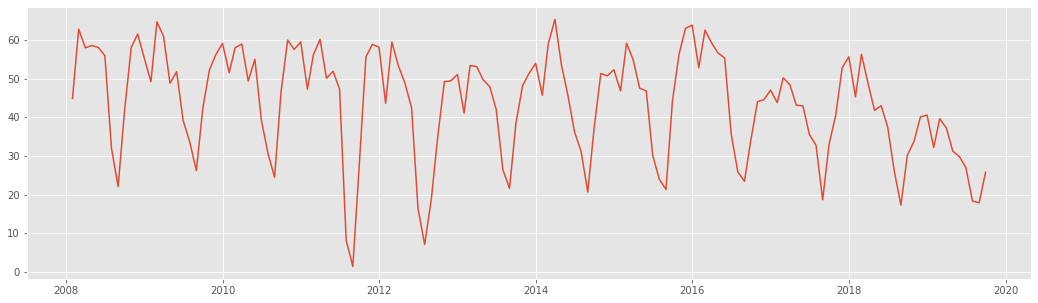

In [10]:
monthly  = palmera_choco.reset_index().groupby(pd.Grouper(key='order_date', freq='M'))['units_ordered'].mean()
plt.plot(monthly)
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as there is always a bump in orders during the middle the year.

We can see also that the series lacks a clear trend.

We also can see that the series presents minimums once a year, being more pronounced at 2011 and 2012.

We aree going to plot a couple of years to check where these minimums occur.

In [11]:
monthly.reset_index().head()

,order_date,units_ordered
0,2008-01-31,44.870968
1,2008-02-29,62.758621
2,2008-03-31,57.935484
3,2008-04-30,58.533333
4,2008-05-31,58.000000


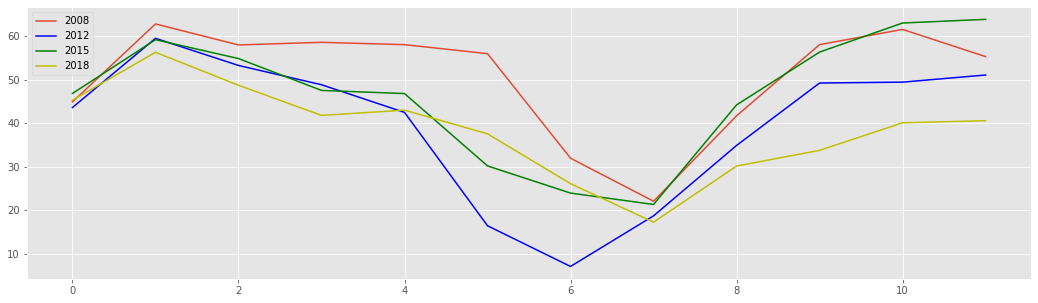

In [12]:
plt.plot(monthly['2008'].reset_index()['units_ordered'])
plt.plot(monthly['2012'].reset_index()['units_ordered'], color='b')
plt.plot(monthly['2015'].reset_index()['units_ordered'], color='g')
plt.plot(monthly['2018'].reset_index()['units_ordered'], color='y')
plt.legend(['2008','2012','2015','2018'])
plt.show()

As we can see, for 3 out of the 4 values plotted, the mininum value is found in the month of August.

For the fourth series, the minimum appears at July.

Maximums appear in January for all series.

We have found that there is a clear yearly seasonality in our series.

Talking about seasonality, we are going to check now for autocorrelations, and we will use the information that we have extracted for our graphs above to use it in our favor when looking for such autocorrelations.

### 1.3) Autocorrelation, ACF and PACF

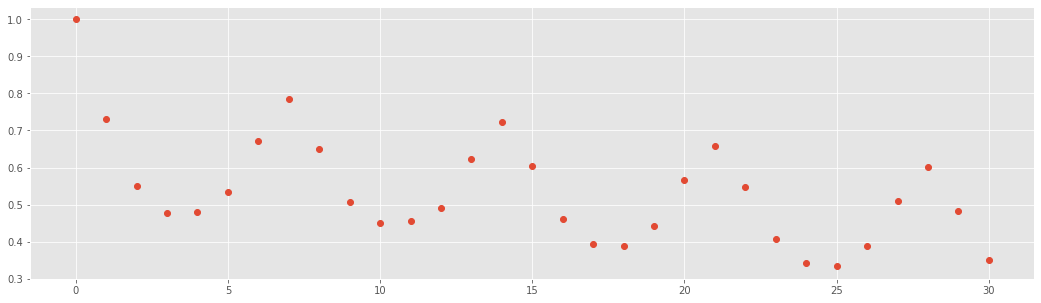

In [13]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

We check the plot with the plot_acf function that statsmodels also provides us, and that includes a visual p-value: a range(that can be seen below, red-shaded region) where values could be due to chance, up to a certain confidence level (or, to be more precise, a region of values that cannot be discarded as being being produced by chance):

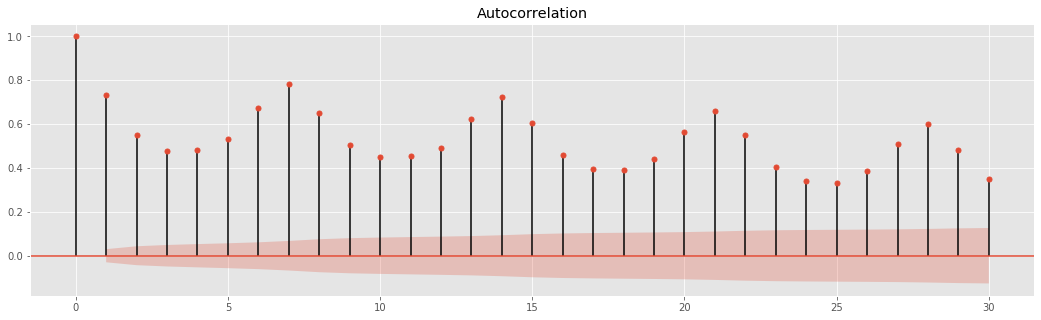

In [14]:
plot_acf(palmera_choco['units_ordered'], lags=30);

As we can see, our series presents both a strong relationship with its n-1 lag (correlation of about 0.75, and also a clear weekly autocorrelation (of about 0.8 - 0.75^6 ≈ 0.6).

As we know, if our process follows an AR(x) model, the value n will have a relation to value n-x of value alpha, then will present a correlation with the value n-2\*x of alpha^2, and a correlation of alpha^3 with the value n-3\*x and so on.

Also, appart from the stated, we cannot discard any of the correlations with the values up to the 7th.

Now, as we saw previously that a strong yearly seasonality existed, we are going now to check for autocorrelations in a more ample spectrum:

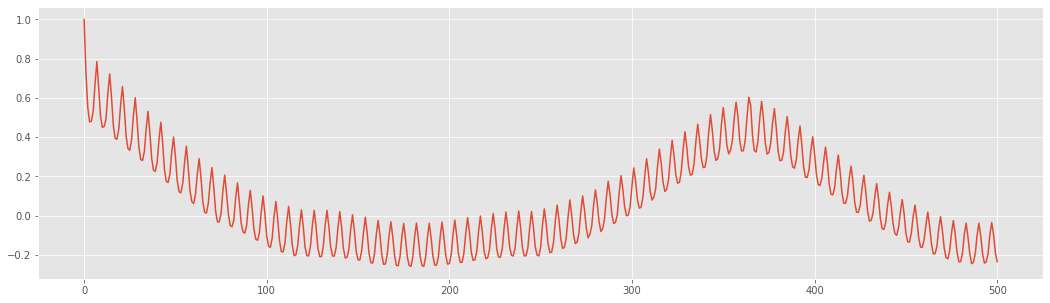

In [15]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=500)

plt.plot(p_choc_acf)

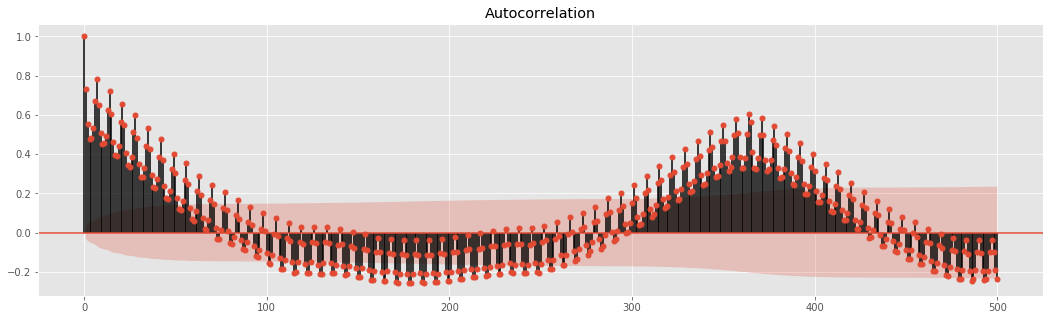

In [16]:
plot_acf(palmera_choco['units_ordered'], lags=500);

As we can see, there is a sinusoidal behaviour, and that the series presents a peak at lag 365.

We are checking that using our average monthly data, so we can get rid off the strong autocorrelations found in our daily series.

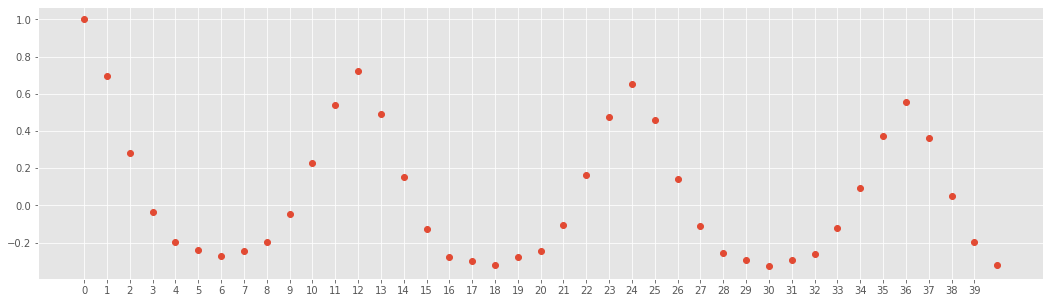

In [17]:
p_choc_acf=stto.acf(monthly, nlags=40)

plt.plot(p_choc_acf,  'o')
plt.xticks(list(range(40)));

We find a strong relationship involving each month with the same month of the previous year, showing, again, the yearly seasonality that we found during section 1.2.

Finally, we are checking the partial autocorrelation function, that shows us how much residual information is explained by adding a new lag.

PACF, instead of finding correlations of present with lags like ACF, finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

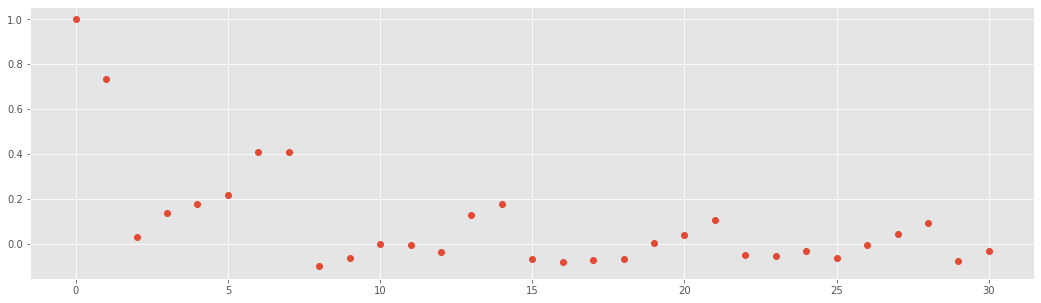

In [18]:
p_choc_acf=stto.pacf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

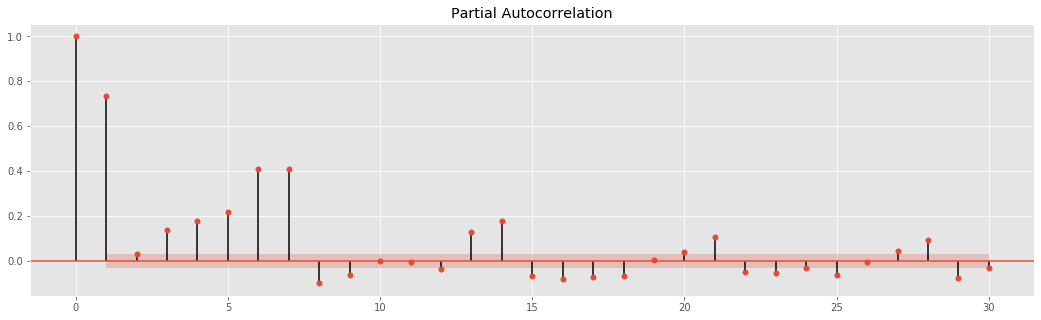

In [19]:
plot_pacf(palmera_choco['units_ordered'], lags=30);

The PACF confirms us what we saw in the acf: the series presents a strong correlation with its first lag (being most of the rest of the spikes merely the result of the propagation of the autocorrelation at lag 1), but there is also a strong autocorrelation with lags 6 and 7. So, in general, autoregressive models of order 7 will be needed to explain the series.

### 1.4) Series decomposition

Finally, to get a better grip on our series before studying it by any methods, we are going now to decompose the series using the seasonal_decompose tool provided in the statsmodel package.

This method uses moving averages to detrend the series and extract the seasonality.

It will give us another first impression on what we can expect about its behaviour, and also what methods should be in order for its analysis and forescasting.

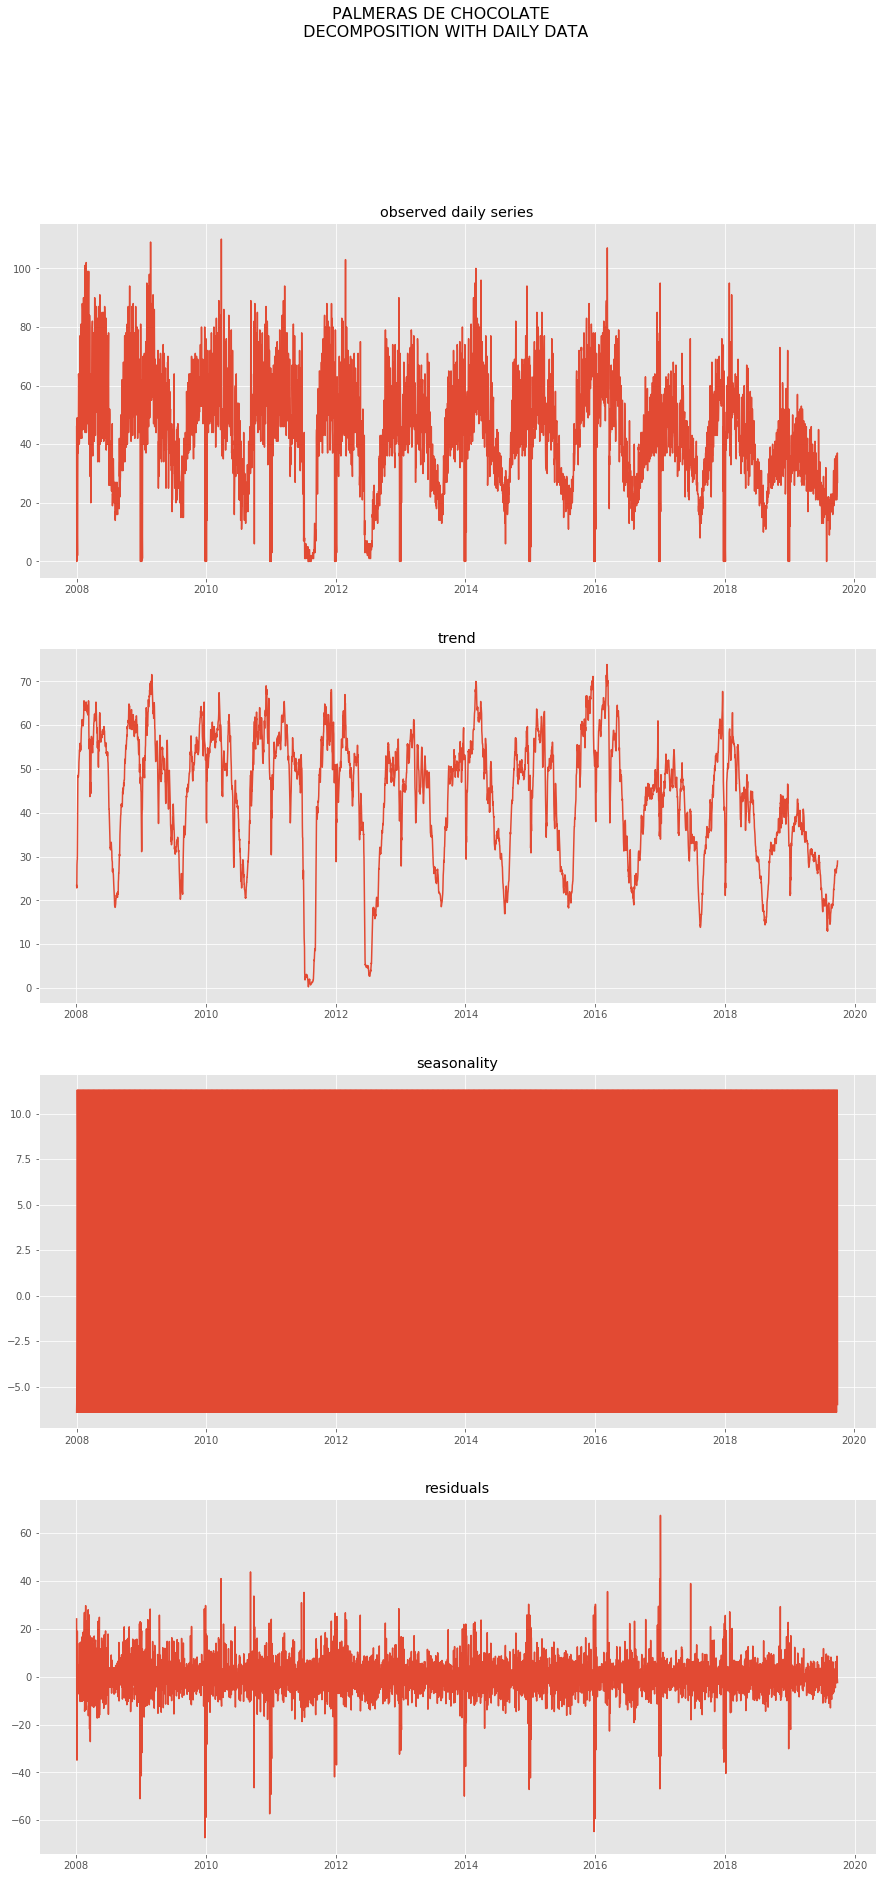

In [20]:
decomposition = seasonal.seasonal_decompose(palmera_choco['units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,30))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');


We cannot see a thing with the whole series, due to the constraints of the image. We are going to run the same procedure with just one year of data:

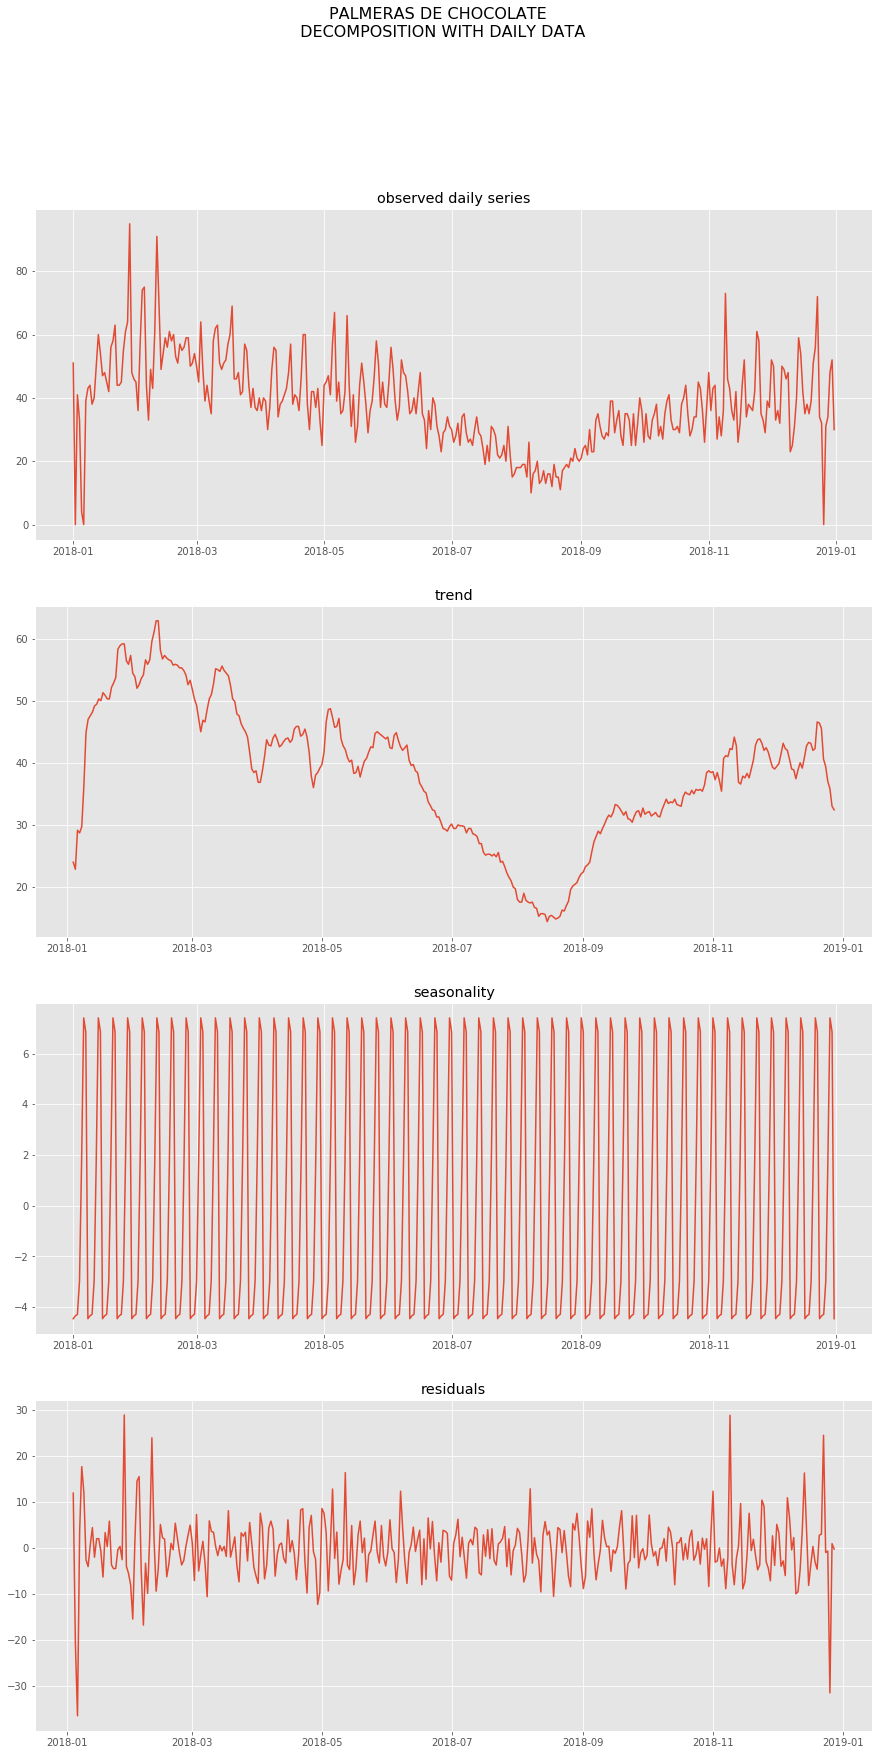

In [21]:
decomposition = seasonal.seasonal_decompose(palmera_choco.loc['2018','units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,28))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

From this decomposition we can extract two main conclusions:

* There is a strong seasonality week component.

* As we can see, the dcomposition is not working well for the series of the daily data. Let's see what it can do with the series of monthly averages:

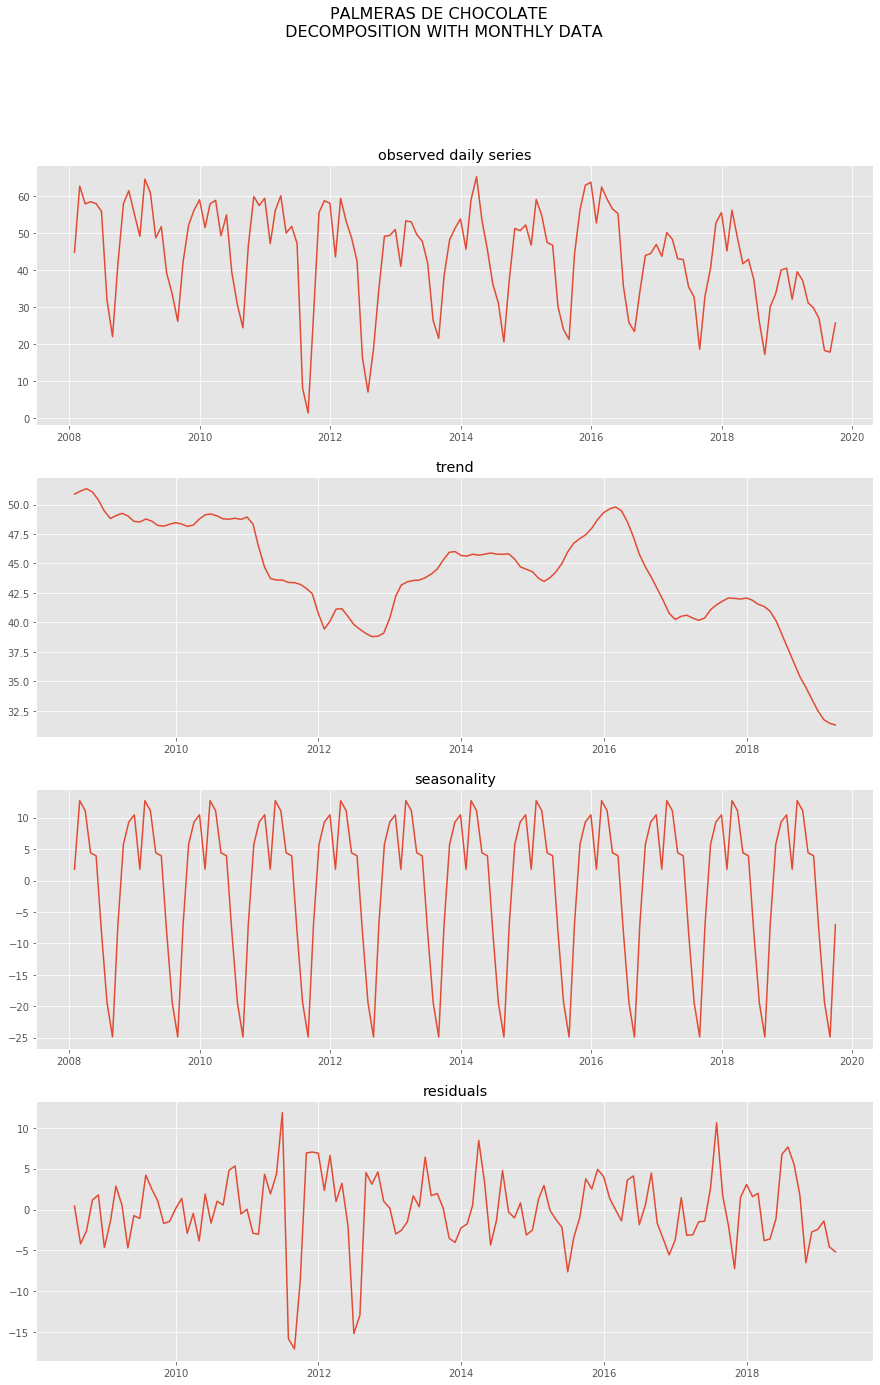

In [22]:
decomposition = seasonal.seasonal_decompose(monthly, model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,22))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH MONTHLY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

# 2) Models application

### 2.0) Split Train-Test, Initialize Results Dictionary and setting benchmarks

In [23]:
# With Feature
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

# Without Features
# train_size = int(len(palmera_choco["units_ordered"]) * 0.95)
# train, test = palmera_choco.iloc[0:train_size,0], palmera_choco.iloc[train_size:,0]

For cross-validation purposes we are going to create a series of 10 randomly-picked intervals for our series.

The horizon to forecast will be of one week, which is the horizon demanded by the client.

Also, as we know, both exponential methods and ARIMA methods loose effectiveness (ARIMA methods loose everything but the trend) from a number of steps head on. So, trying to forecast big intervals ahead is not sensible.

For machine learning methods we will have to train one model for each day ahead that we want to predict, so, trying to predict many days in advance would require training the same number of different machine learning models, one for each day.

The data used to train our models will be the year before that week. Doing it so, we know that we loose the yearly-pattern seasonality that we found.

We initially don't care for this yearly seasonality.

The motives are as follow:
    
    1) for each model, including lags up to the 365 is clearly excessive.
    2) if it is necessary, to include the yearly seasonality would be easy, we would need only to differenciate the series with its 365th lag, and run this same models on the resulting series.
    3) we can also calculate the mean values for a cycle of 365 days and take it from the series, and operate with the resulting series.



In [24]:
series = palmera_choco["units_ordered"]

random.seed(17)

number_of_validations = 12
horizon = 7
data_for_pred = 365

cross_val_dict=dict()

for i in range(1,number_of_validations + 1):

    ran_num = random.randint(365,len(series))
    ran_test_dates = series.reset_index().iloc[ran_num:ran_num + horizon]['order_date']
    ran_train_dates = series.reset_index().iloc[ran_num - data_for_pred:ran_num]['order_date']

    test = series[ran_test_dates]
    train = series[ran_train_dates]

    cross_val_dict['cv'+str(i)]=[train, test]

We create now an empty dictionary where we will input the error obtained by each method used.

In [25]:
# Error per model Dictionary
mse_all_models = {} 

We are now going to set our benchmarks for comparison:

**BENCHMARK 1:**

USING THE MEAN AS A GUESS:

Our first "model" will be: Using the mean (of the previous year) as a guess (the most basic model). This first value will provide us with a first tool to calibrate the other two models that we are going to use for benchmarking our time series and machine learning models.

As we said before, we are going to cross-validate our results running each model 10 times in different, randomly-picked, parts of the series, obtaining the mean of the mean squared errors commited, and the mean distribution of those mean squared errors:

In [26]:
mean_mse_mean = 0
mean_mse_series_mean =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_mean = train.mean()
    print("mean (model predicted value):", train_mean)
    squared_dif_series=(test - train_mean)**2
    print("MSE:", (squared_dif_series).mean())
    
    mean_mse_mean += (squared_dif_series).mean()
    
    mean_mse_series_mean += np.array(squared_dif_series)

mean_mse_mean = mean_mse_mean/number_of_validations
mean_mse_series_mean=pd.Series(mean_mse_series_mean/horizon)

print("mean MSE:", mean_mse_mean)

mean (model predicted value): 45.84109589041096
MSE: 67.3097906334611
mean (model predicted value): 43.106849315068494
MSE: 479.9069157976572
mean (model predicted value): 41.131506849315066
MSE: 145.14645256413698
mean (model predicted value): 42.13972602739726
MSE: 121.12480712007077
mean (model predicted value): 39.04109589041096
MSE: 399.6279119641852
mean (model predicted value): 42.73972602739726
MSE: 184.7428893118516
mean (model predicted value): 49.221917808219175
MSE: 249.27938449990629
mean (model predicted value): 40.76986301369863
MSE: 421.72732702463617
mean (model predicted value): 46.723287671232875
MSE: 71.69927029997586
mean (model predicted value): 46.821917808219176
MSE: 81.14521620245021
mean (model predicted value): 45.56164383561644
MSE: 254.6559526043482
mean (model predicted value): 49.082191780821915
MSE: 115.9656595984237
mean (model predicted value): 43.16438356164384
MSE: 402.9663565933034
mean (model predicted value): 48.04931506849315
MSE: 657.48305819907

As we can see, there is a big dispersion in the MSE values, depending on the series used. This remarks the great importance of using cross-validation techniques when evaluating a model.

The MSE for this burd method is 225, aproximately.

We now plot the results for the last of our models:

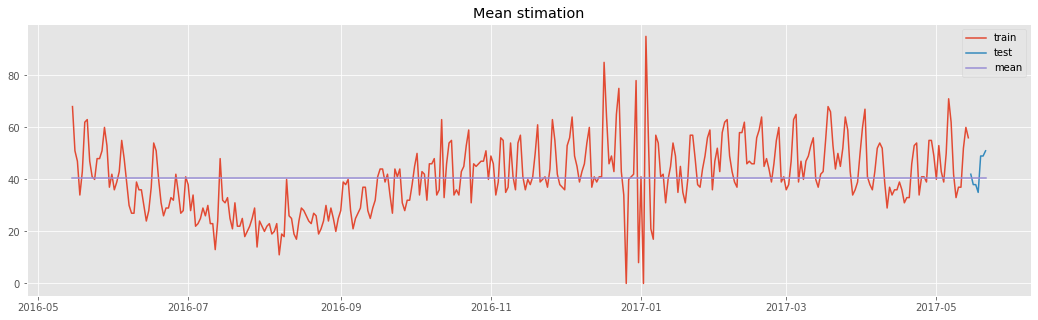

In [27]:
mean_model = pd.Series(train_mean, index = train.index.union(test.index))

plt.plot(train)
plt.plot(test)
plt.plot(mean_model)
plt.legend(['train','test','mean'])
plt.title("Mean stimation");

As we can see, the mean fails to capture any trend along the cycle, nor the weekly seasonality.

Evidently, the results should get better when replacing this simple average with a moving average that follows the series, but the purpose of this method is just setting a benchmark.

In [28]:
mse_all_models["general_mean"] = mean_mse_mean

**BENCHMARK 2:**
    
MEAN OF JUST SAME DAYS OF THE WEEK:
    
Now we will use as our guess the mean of the values of the same weekday of the year before:

Firstly, to compare this model to the previous one, we are going to check it just for a particular one: the last scenario of the 10 randomly defined for our cross-validation purposes:

In [29]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

In [30]:
train_means_by_weekday = train.groupby(train.index.weekday).mean()
print(train_means_by_weekday)
print("mean value for the same series:", train_mean)

order_date
0    37.980769
1    36.132075
2    38.096154
3    39.192308
4    43.980769
5    48.403846
6    48.711538
Name: units_ordered, dtype: float64
mean value for the same series: 40.673972602739724


As we can see, when compared with the general mean, we have now a series of values, one for each weekday, that present  certain dispersion. 

As now our guesses should be wiser, our median average error should go down, but any scenario is possible a priori.

In [31]:
mean_mse_mult_means = 0
mean_mse_series_mult_means =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_means_by_weekday = train.groupby(train.index.weekday).mean()
    test_df=test.reset_index()
    test_df['weekday'] = test.index.weekday
    df_train_means_by_weekday = train_means_by_weekday.reset_index()
    df_train_means_by_weekday.columns = ['weekday','prediction']

    test_result_merged = pd.merge(test_df, df_train_means_by_weekday, how='inner', on='weekday')
    test_result_merged.set_index(test_result_merged['order_date'], inplace=True)
    test_result_merged.sort_index(inplace=True)
    
    test_result_merged['Sq_error'] = (test_result_merged['units_ordered'] - test_result_merged['prediction'])**2

    mean_mse_mult_means += test_result_merged['Sq_error'].mean()
    
    mean_mse_series_mult_means += np.array(test_result_merged['Sq_error'])
    
    print("MSE:", test_result_merged['Sq_error'].mean())
    
mean_mse_mult_means = mean_mse_mult_means/number_of_validations
mean_mse_series_mult_means=pd.Series(mean_mse_series_mult_means/horizon)

print("mean MSE:", mean_mse_mult_means)

MSE: 31.359863402473696
MSE: 511.80309569801454
MSE: 97.65877348409457
MSE: 55.59690797331488
MSE: 306.0090280659588
MSE: 50.315730788640664
MSE: 221.35390289017883
MSE: 431.0688412810592
MSE: 17.64218908128593
MSE: 27.16946425599759
MSE: 131.15706323142584
MSE: 71.96203888705156
MSE: 415.6389475908707
MSE: 401.22259096846955
MSE: 59.89973975691587
MSE: 63.76297158526497
MSE: 94.60346648723295
MSE: 126.5647405453489
MSE: 190.76406414429286
MSE: 14.20216713004661
mean MSE: 165.98777936239694


We can see that our predictions are better, because our mean error has dropped almost 30%.

We want to remark, again, the dispersion of the values and the importance of using cross-validation techniques.

Now, we plot the values of the model against the real values, for the last iteration:

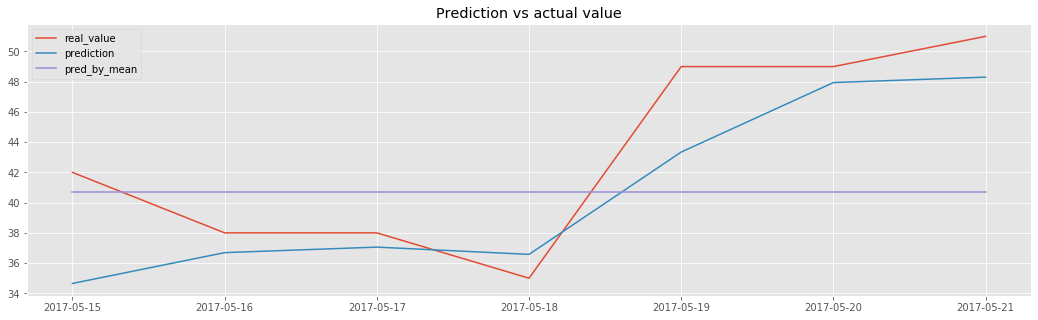

In [32]:
plt.plot(test_result_merged['units_ordered'])
plt.plot(test_result_merged['prediction'])
plt.plot(mean_model[test.index])
plt.legend(['real_value','prediction','pred_by_mean'])
plt.title('Prediction vs actual value');

As we can see, not only the mean error commited is lower, but also, the new benchmark model now adjusts well to the weekly seasonality. 

Let's check now how this is translated in the distributions of the mean errors:

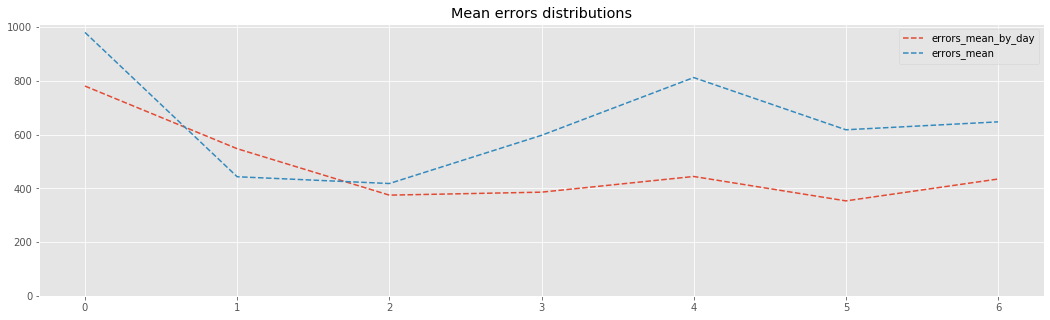

In [53]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_mult_means, '--')
ax.plot(mean_mse_series_mean, '--')
ax.legend(['errors_mean_by_day','errors_mean'])
ax.set_ylim(bottom=0)
plt.title('Mean errors distributions');

Our error is not only significantly lower, but also more uniform in its distribution along time, which is another factor to keep in mind.

In [34]:
mse_all_models["weekday_means"] = mean_mse_mult_means

**BENCHMARK 3:**
    
NAÎVE GUESS:
    
Now we are going to predict the values of our series just by using the last value available, again, for the same day of the week.

In [35]:
mean_mse_naive = 0
mean_mse_series_naive =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_bm3 = train[-horizon:]
    train_bm3.index = train_bm3.index + timedelta(days=7)
    pred_bm3 = test.shift(7)
    pred_bm3.fillna(0, inplace=True)
    pred_bm3[0:7] = pred_bm3[0:7] + train_bm3
    df_bm3 = pd.DataFrame(test)
    df_bm3['prediction'] = pred_bm3
    df_bm3['Sq_error'] = (df_bm3['units_ordered'] - df_bm3['prediction'])**2
    df_bm3['Sq_error'].mean()
    
    print("MSE:", df_bm3['Sq_error'].mean())
    
    mean_mse_naive += df_bm3['Sq_error'].mean()   
    mean_mse_series_naive += np.array(squared_dif_series)
    
mean_mse_naive = mean_mse_naive/number_of_validations
mean_mse_series_naive = pd.Series(mean_mse_series_naive/horizon)

print("mean MSE:", mean_mse_naive)

MSE: 81.28571428571429
MSE: 8.714285714285714
MSE: 28.428571428571427
MSE: 203.28571428571428
MSE: 95.85714285714286
MSE: 133.42857142857142
MSE: 182.85714285714286
MSE: 69.85714285714286
MSE: 28.0
MSE: 32.714285714285715
MSE: 141.28571428571428
MSE: 69.57142857142857
MSE: 220.14285714285714
MSE: 136.0
MSE: 44.285714285714285
MSE: 260.2857142857143
MSE: 105.85714285714286
MSE: 42.42857142857143
MSE: 5.857142857142857
MSE: 26.428571428571427
mean MSE: 95.82857142857142


We can see that the mean MSE has almost halved. This suggests that guessing the values of the series with the same equivalent value from a week ago is a much better guess than using averages of any kind, what in turn, tells us that using just a small series of lags should give us good predictions.

Now, plotting the distributions:

Text(0.5, 1.0, 'Prediction vs actual value')

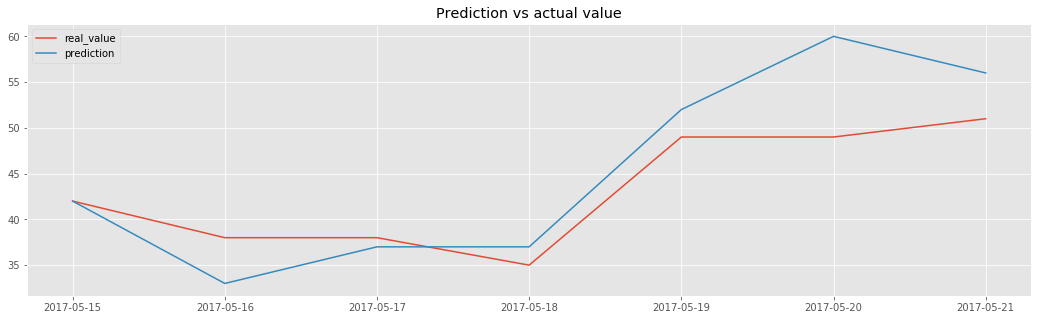

In [36]:
plt.plot(df_bm3['units_ordered'])
plt.plot(df_bm3['prediction'])
plt.legend(['real_value','prediction'])
plt.title('Prediction vs actual value')

We can see that the series again is capable of adjusting to the week pattern, as in the previous case.

Let's see now the distribution of errors:

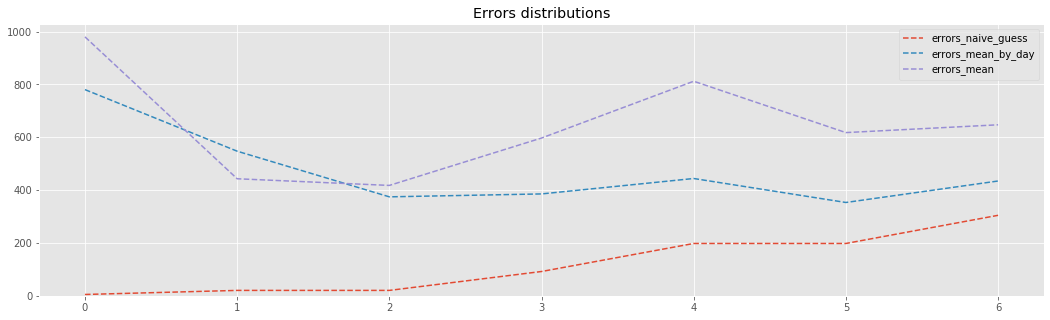

In [54]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_mult_means, '--')
ax.plot(mean_mse_series_mean, '--')
ax.set_ylim(bottom=0)
ax.legend(['errors_naive_guess','errors_mean_by_day','errors_mean'])
plt.title('Errors distributions');

In [38]:
mse_all_models["Naîve_guess"] = mean_mse_naive

We can see that, in this case, not only we have a more homogeneous distribution of error, but also that they are all lower than in two previous cases.

**CONCLUSSIONS:**

**The information just previous to our forecast seems to be of greater value than historical data.**

**As we could see earlier, the weekly pattern is of great importance in this series, and has to be acknowledged.**

**Any model with a mean MSE greater than 82 will behave worse than a mere naîve guess (using the same value of the previous week). We will use this value as a threshold, but all three values (214 for the mean, 172 for the weekly means and 82 for the naîve guess) to compare with those of our methods.**

**From the disperssion of the values of MSE obtained for each of these three methods we can infer the great importance of doing cross-validation of the different methods.**

Now, we can start evaluating different methods.

### 2.1) TIME SERIES METHODS

Now, we can start using time series methods for our forecasts.

### 2.1.1) EXPONENTIAL MODELS

Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models.

For each method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals.

We label each state space model as ETS(.,.,.) for (Error, Trend, Seasonal). This label can also be thought of as ExponenTial Smoothing, where  the possibilities for each component are:

 - Error: Additive, Multiplicative
 - Trend: None, Additive, Additive and damped
 - Seasonal: None, Additive, Multiplicative
 
 
 This leads to the following map:
 
<img src=".\statespacemodels.png" style="width: 620px;">


Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are ETS(A,N,M), ETS(A,A,M), and ETS(A,Ad,M), due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.

Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only the six fully additive models will be applied.

Source:

https://otexts.com/fpp2/ets.html

So, being that our case, we will opt for an Additive Holt-Winters’ method (an exponential method with additive trend and additive seasonality) with additive errors.

This model is atractive for us, because it can detect trends and supports seasonality, which in our case is a weekly seasonality.

In [39]:
mean_mse_ES = 0
mean_mse_series_ES =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    ES_model = ExponentialSmoothing(train, trend='add', seasonal='add', damped=False, seasonal_periods=7)
    ES_model = ES_model.fit()

    ES_resid = ES_model.resid
    ES_aic = ES_model.aic

    ES_pred = ES_model.predict(start = test.index[0], end = test.index[-1])

    ES_mse = (test - ES_pred)**2
    
    print("MSE:", ES_mse.mean())
    
    mean_mse_ES += ES_mse.mean()   
    mean_mse_series_ES += np.array(ES_mse)
    
mean_mse_ES = mean_mse_ES/number_of_validations
mean_mse_series_ES = pd.Series(mean_mse_series_ES/horizon)

print("mean MSE:", mean_mse_ES)

MSE: 37.97813784094426
MSE: 23.118786827949652
MSE: 37.28492912056488
MSE: 82.18156886434507
MSE: 88.64884181627649
MSE: 59.552349818388926
MSE: 64.8388367151622
MSE: 97.18171770957238
MSE: 27.533529211870434
MSE: 23.831391343537167
MSE: 118.6657191428789
MSE: 46.290550095355016
MSE: 161.1319219726137
MSE: 364.6175581489292
MSE: 38.34948276340803
MSE: 92.66976785336135
MSE: 123.24705641498187
MSE: 37.92877305166337
MSE: 10.223340526983353
MSE: 22.977603128523526
mean MSE: 77.91259311836548


As we can see, our MSE is lower than the naîve guess value that we decided would be our threshold.

So, a priori, this model improves our situation over just selecting the last value for the same weekday, and would eligible.

Let's plot now the last prediction and the real series:

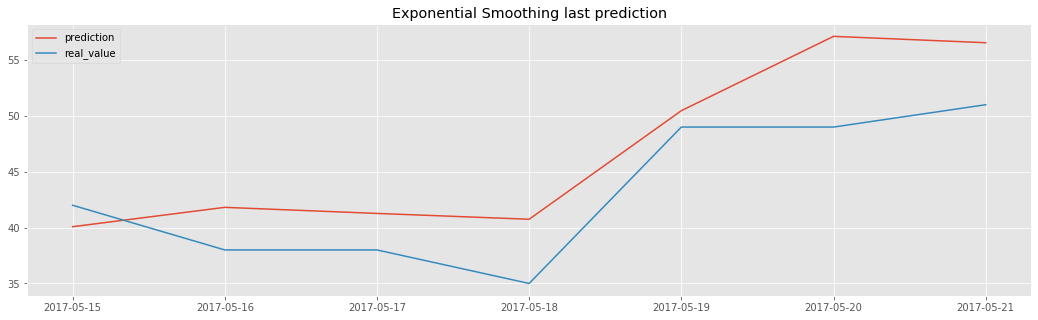

In [40]:
plt.plot(ES_pred)
plt.plot(test)
plt.legend(['prediction','real_value'])
plt.title("Exponential Smoothing last prediction");

And now, the resulting mean distribution of the MSE:

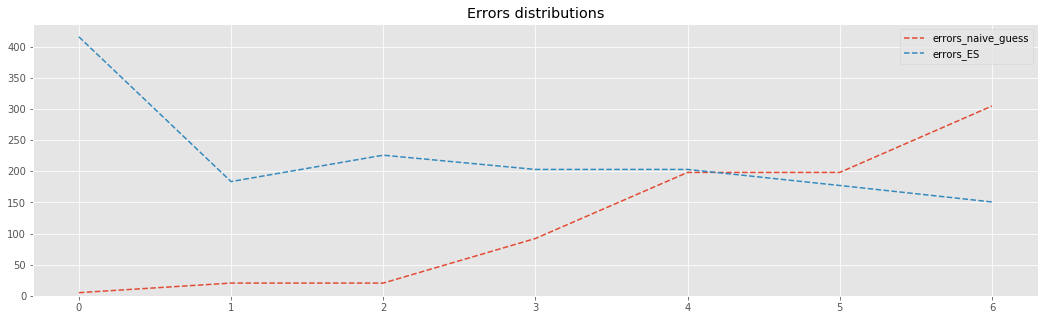

In [41]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_ES, '--')

ax.set_ylim(bottom=0)

plt.legend(['errors_naive_guess','errors_ES'])
plt.title('Errors distributions');

In [42]:
mse_all_models["Holt-Winters"] = mean_mse_ES

### 2.1.2) ARIMA

Now we are going to try out the standard ARIMA model.

From the analysis performed during the first part of our notebook, (specifically, from the acf and pacf analysis) we know that an AR(7) model is in order.

We also know, as the series is already stationary, that no differencing would be needed, although can be convenient.

Let's study the matter a little more in depth:

**CHECKING FOR DIFFERENCING:**

WWe are now going to check the optimal order of differencing for our series. We will follow the following rules:

Identifying the order of differencing and the constant:

Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.

Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.

Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)

Rule 4: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).

Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.

Source: https://people.duke.edu/~rnau/arimrule.htm
    
If the differenced series presents a negative correlation with its lag-1 value, the series would be slighly overdifferenced:

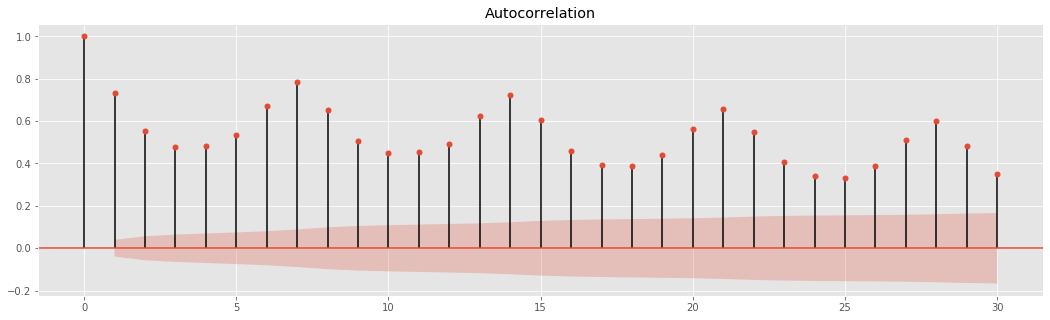

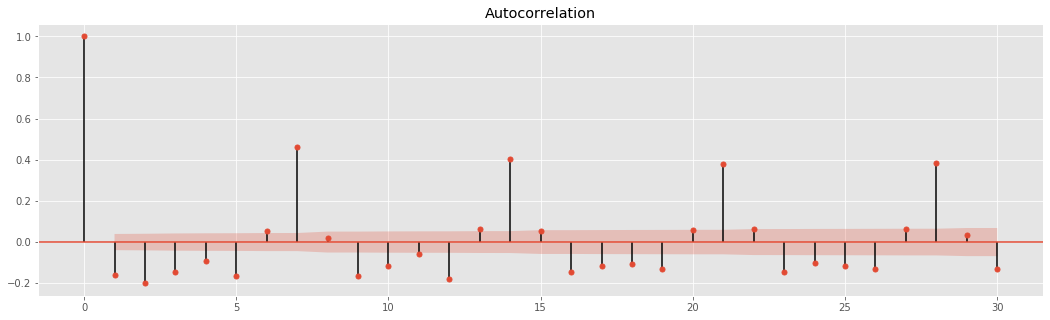

In [43]:
dif_series_1 = series.diff(1).dropna()
plot_acf(series, lags = 30, alpha= 0.01)
plot_acf(dif_series_1, lags = 30, alpha= 0.01);

In [44]:
print(series.std())
print(dif_series_1.std())

18.076183830888187
13.226164709895148


Following the rules, the order of differencing for our models can only be 0 or 1.

0 because it is already stationary, and an AR(7) model seems appropriate to deal with the existing autocorrelations up to lag 7, but, as shown above, it seems also appropriate to use a d=1, to remove the effect of lag 1 in the series, and let the AR part of the model deal with the rest of the autocorrelations.

we are going to try out both strategies.

**STIMATING THE MA COEFFICIENTS:**

What we don't know yet is the coefficient for the MA part of the model.

As we know, if the acf had returned a spike (for instance, at lag 1), but not any other spike at any multiples of this lag, that would indicate the existence of an MA component, of order, the order of the lag (in case of the presence of a spike at lag 1, and not any other lag, that would lead us to a MA(1) model).

Nevertheless, when there are effects of an autoregression, they can compound to the effects of a possible MA.

Or as it is expressed in https://people.duke.edu/~rnau/411arim3.htm:

*AR and MA signatures: If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. You will probably find that an AR signature is commonly associated with positive autocorrelation at lag 1--i.e., it tends to arise in series which are slightly underdifferenced. The reason for this is that an AR term can act like a "partial difference" in the forecasting equation. For example, in an AR(1) model, the AR term acts like a first difference if the autoregressive coefficient is equal to 1, it does nothing if the autoregressive coefficient is zero, and it acts like a partial difference if the coefficient is between 0 and 1. So, if the series is slightly underdifferenced--i.e. if the nonstationary pattern of positive autocorrelation has not completely been eliminated, it will "ask for" a partial difference by displaying an AR signature.

(...)

*In principle, any autocorrelation pattern can be removed from a stationarized series by adding enough autoregressive terms (lags of the stationarized series) to the forecasting equation, and the PACF tells you how many such terms are likely be needed. However, this is not always the simplest way to explain a given pattern of autocorrelation: sometimes it is more efficient to add MA terms (lags of the forecast errors) instead. The autocorrelation function (ACF) plays the same role for MA terms that the PACF plays for AR terms--that is, the ACF tells you how many MA terms are likely to be needed to remove the remaining autocorrelation from the differenced series. If the autocorrelation is significant at lag k but not at any higher lags--i.e., if the ACF "cuts off" at lag k--this indicates that exactly k MA terms should be used in the forecasting equation. In the latter case, we say that the stationarized series displays an "MA signature," meaning that the autocorrelation pattern can be explained more easily by adding MA terms than by adding AR terms.*

For identifying the numbers of the MA terms we will follow the following rules:

Identifying the numbers of AR and MA terms:

Rule 6: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

Rule 8: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.

Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.

Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

So, from the above acf, we can see that, if we go for a d=0 model, the MA is difficult to determine (we will pick MA=0 and MA=1 in this case)

For a d=1 model, it seems that the we should go for a MA=7 model.

So, our candidates should be ARIMA(7,0,0), ARIMA(7,0,1), ARIMA(7,0,7), ARIMA(7,1,0), ARIMA(7,1,1) and ARIMA(7,1,7)

To these models, we are going to add a bunch of other models as control for the AIC criterion (maybe we can do good enough using less information, and we want to check that we are doing things right).

(We need to keep in mind the need for invertibility of the coefficients of the MA model)

Firstly, we take define the models we are going to try out:

In [45]:
orders=[(1,0,0),(1,0,1),(2,0,0),(2,0,1),(7,0,0),(7,0,1),(7,0,7),(7,1,0),(7,1,1),(7,1,2),(7,1,7)]

Secondly, we select one specific set of train, test conditions:

In [46]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

We now try out a single ARIMA model on such conditions:

In [55]:
order = (7,1,1)

ARIMA_model = ARIMA(train, order = order)
ARIMA_model = ARIMA_model.fit()

print(ARIMA_model.summary)

ARIMA_resid = ARIMA_model.resid
ARIMA_aic = ARIMA_model.aic

if order[1] == 0:
    ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1])
else:
    ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1], typ='levels')

ARIMA_mse = (test - ARIMA_pred)**2

print(ARIMA_mse.mean())
print(ARIMA_aic)

<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARIMAResults object at 0x0000021C91D21B00>>
5.947617969866289
2670.4777171875644


Text(0.5, 1.0, 'ARIMA prediction')

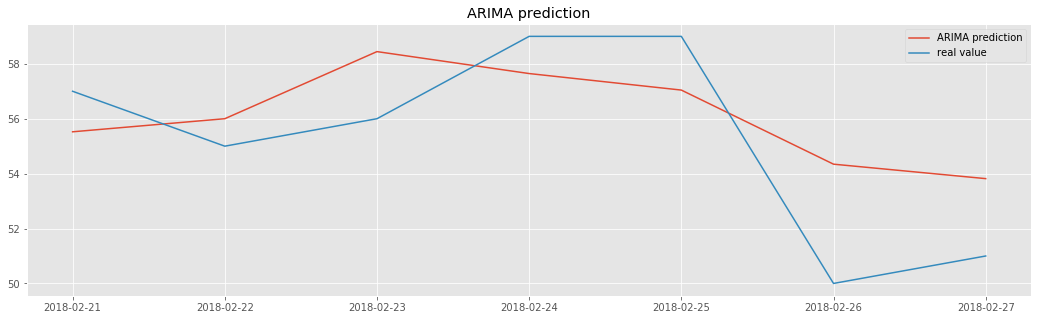

In [58]:
# Plot the original series and the forecasted series
plt.plot(ARIMA_pred)
plt.plot(test)
plt.legend(["ARIMA prediction", "real value"])
plt.title("ARIMA prediction")

We define now a function that obtains all this values for us:

In [59]:
# evaluate an ARIMA model:

def eval_arima_model(arima_order, train , test):
    
    # Making sure that what the model reveives is a tuple:
    
    arima_order=tuple(arima_order)
    
    # Creatting and fitting the model:

    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    # Storing results:
    
    model_summary = model_fit.summary

    model_resid = model_fit.resid
    model_aic = model_fit.aic
    
    # Storing prediction:
    
    # The if-else clause is needed because the predict method requires to indicate how yo need your result in case
    # a model with differences is applied, but, on the other hand, doesn't handle the typ parameter when the model
    # works directly wiith the original series:
    
    if arima_order[1] == 0:
        model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
    else:
        model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1], typ='levels')

    # Calculate out of sample error:
    
    model_error = mean_squared_error(test, model_prediction)
    
    # Returning the values:
    
    return model_summary, model_prediction, model_resid, model_aic, model_error

Checking that the function works propperly:

In [61]:
ARIMA_summary, ARIMA_resid, yhat, ARIMA_aic, ARIMA_error = eval_arima_model((7,1,1), train, test)
print(ARIMA_error)
print(ARIMA_aic)
print(ARIMA_summary)
# print(ARIMA_resid)
# print(yhat)

5.947617969866289
2670.4777171875644
<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARIMAResults object at 0x0000021C8E085208>>


Now, we use this function to try out several different combinations for the parameters of the ARIMA model.

We define below a function that receives the list or orders one wants to try, and the dictionary with the test and train information stored, and tries out for each scenario defined in this dictionary, for each model given:

In [62]:
# evaluate combinations of p, d and q values for an ARIMA model

def evaluate_ARIMA(orders, cross_val_dict):

    # Initializing variables:
    
    model_summ, model_pred, model_res, model_aic, model_error  = None, None, None, None, float("inf")
    b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA = None, None, None, None, float("inf")
    
    b_mean_mse_series_ARIMA = None
    
    # as in previous cases, we want to evaluate our errors on average, 
    #so we run our process several times to get mean values:

    for order in orders:
        
        # This is a loop control variable that exits all iterations over our test data if the model could not be fitted
        # for any of them:
        
        control=1
        
        mean_mse_ARIMA, mean_ARIMA_aic = 0, 0
        mean_mse_series_ARIMA = np.array([0.0]*horizon)
        
        for key, data in cross_val_dict.items():
    
            train = data[0]
            test = data[1]
            
            # tries to apply the eval_arima_model function with the order indicated.
            # if it does cannot apply it (because of irreversibility on the initial coefficients), prints a warning and breaks
            
            try:
                model_summ, model_pred, model_res, model_aic, model_error = eval_arima_model(order, train, test)
#                 print(order, key)
                
            except:
                print("ARIMA ", order," model could not be fitted for ", key, " test data")
                control=0
                continue
                
            # Aggregating the results for the current loop to the squared errors series, the total error and the aic
            # of our model:

            squared_dif_series = (model_pred - test)**2

            mean_mse_ARIMA += model_error
            mean_ARIMA_aic += model_aic

            mean_mse_series_ARIMA += np.array(squared_dif_series)
            
        # After all iterations, we divide by the number of validations to obtain mean values:

        mean_mse_ARIMA = mean_mse_ARIMA/number_of_validations
        mean_ARIMA_aic = mean_ARIMA_aic/number_of_validations
        mean_mse_series_ARIMA=pd.Series(mean_mse_series_ARIMA/horizon)
        
        # Now we store the values of the best model (in terms of MSE):

        if (mean_mse_ARIMA < b_mean_mse_ARIMA) & control==1:
            
            b_mean_mse_ARIMA = mean_mse_ARIMA
            b_mean_ARIMA_aic = mean_ARIMA_aic
            b_mean_mse_series_ARIMA = mean_mse_series_ARIMA

            b_model_summ, b_model_pred, b_model_res = model_summ, model_pred, model_res
            
            b_order = order
            
        # Printing out average error values for the current model:

        print('ARIMA %s MSE=%s AIC=%s' % (order, mean_mse_ARIMA, mean_ARIMA_aic))
        
    # Printing out average error values for the best model:
                    
    print('Best ARIMA %s MSE=%s AIC=%s' % (b_order, b_mean_mse_ARIMA, b_mean_ARIMA_aic))
    
    # Returning the data of the best model:
    
    return b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA, b_mean_mse_series_ARIMA

We are now ready to try out our models:

In [63]:
b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA, b_mean_mse_series_ARIMA = evaluate_ARIMA(orders, cross_val_dict)

ARIMA (1, 0, 0) MSE=194.86359030097645 AIC=2846.8338999221573
ARIMA (1, 0, 1) MSE=177.39287872316365 AIC=2840.0508048049146
ARIMA (2, 0, 0) MSE=197.45077222896998 AIC=2846.4094163616614
ARIMA (2, 0, 1) MSE=156.05380484042547 AIC=2808.732269195717
ARIMA (7, 0, 0) MSE=87.30872242160628 AIC=2704.5465259876178
ARIMA (7, 0, 1) MSE=89.77331346344872 AIC=2703.620515114557
ARIMA  (7, 0, 7)  model could not be fitted for  cv2  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv3  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv4  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv5  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv6  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv7  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv8  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv11  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv12  test data
ARIMA  (7, 0, 7)  model could not be fitted for  cv14 

As we can see, our function has selected the ARIMA(7,0,0) model, in spite of existing other with smaller MSE values.

This is because in the function we defined that if the model could not be fitted for all the different scenarios, the model would not be eligible.

(In regards to those low MSE and AIC values: they are not real, because they are divided by the total number of cases, not taking in consideration that in several of them the process has failed, so their values are artificially low. Correcting this to show real values was of no interest, as these models do not grant us an all-around aplicability)

Appart from that, it is remarkable how much the error goes down when jumping from ARIMA(2,X,X) models to ARIMA(7,X,X) models, showing the great importance of the lags 6 and 7 for each value.

It is also remarkable that two other models got results very similar to the ARIMA(7,0,0): those models are also the ARIMA(7,1,1) model and the ARIMA(7,1,0) model.

Let's now plot the results for the ARIMA(7,0,0) model:

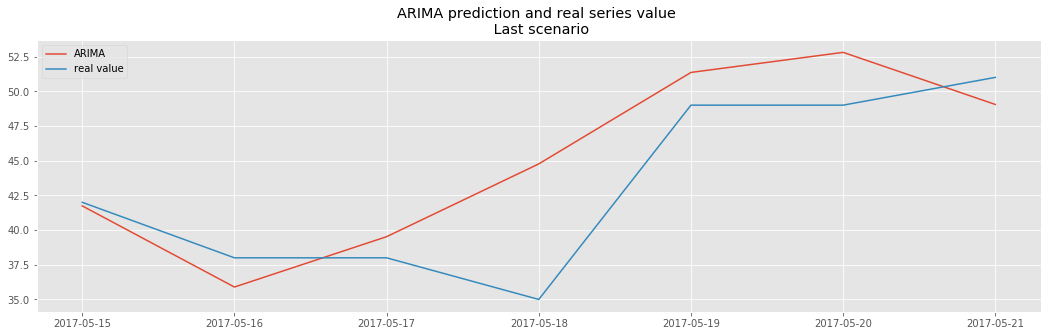

In [88]:
plt.plot(b_model_pred)
plt.plot(cross_val_dict['cv'+str(number_of_validations)][1])
plt.legend(["ARIMA", "real value"])
plt.title("ARIMA prediction and real series value \n Last scenario");

And we also plot the distribution of errors, and compare it with those of the exponential method:

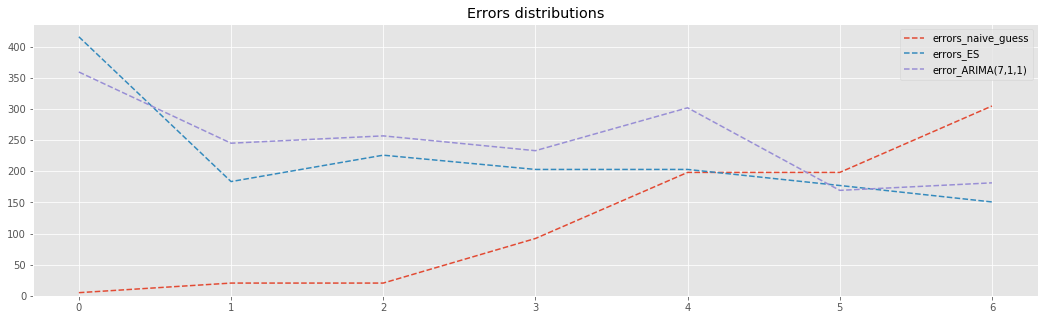

In [65]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_ES, '--')
ax.plot(b_mean_mse_series_ARIMA, '--')

ax.set_ylim(bottom=0)

plt.legend(['errors_naive_guess','errors_ES','error_ARIMA(7,1,1)'])
plt.title('Errors distributions');

In [66]:
mse_all_models["ARIMA"] = b_mean_mse_ARIMA

### 2.3) SARIMA

As we have seen, the traditional ARIMA method has worked out for us in the line of the exponential smoothing methods, but slightly worse.

We have to take into consideration that classical ARIMA methods doesn't allow us to handle seasonality in our data.

That's the reason that we have had to use up to 7 lags to get a decent MSE score.

We could have used other methods to handle this seasonality, such as applying the ARIMA to the series differenced with its 7th lag (series.diff(7)), for intance, but that has the inconvenience of having to undo changes manually later.

(By the way, this would be also one of the ways of handling the yearly seasonality that we found in our data and are currently not exploiting).

But the battery of ARIMA methods provides us with a different tool: for handling seasonality, we have the Seasonal ARIMA methods, or SARIMA.

Python provides us the SARIMAX tool, which is a mix of the SARIMA and ARIMAX methods, and that not only allows us to handle seasonality but also introducing external data for studying correlations between SARIMA residuals and the data introduced.

We are going to try it out now, and check wether any improvement from the traditional ARIMA occurs:

In [67]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

Having now the possibility of handling seasonality appart allows us a greater flexibility in the use of the model.

As we can see from the pacf:

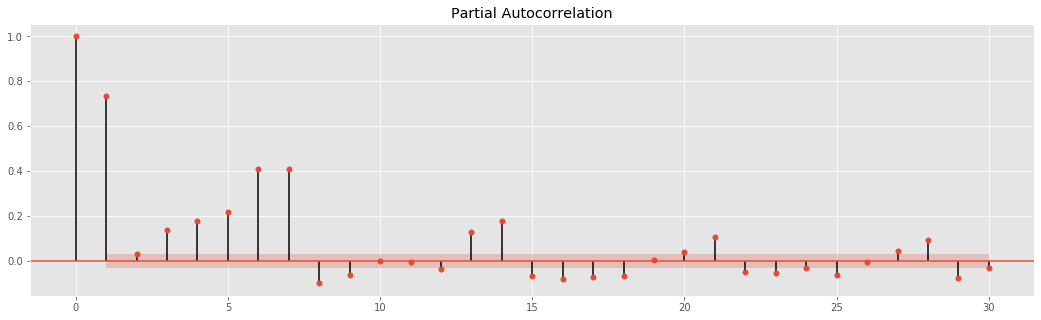

In [68]:
plot_pacf(series, lags=30);

An acceptable model could be designed with an (1,1,0) or (1,1,1) coefficients for the ARIMA and a $(1,1,0)_7$ or $(1,1,1)_7$ for the seasonal part.

We would be paying attention then only to lags 1 and 7, skipping the rest (what would lead us to a simpler, nicer and less demanding numerically program).

The presence of the spikes at lags 3,4,5 and specially, 6, undermines our confidence in such models, and would probably drag the performance of such a model.

So, the optimal model would probably be a (6,1,0) or (6,1,1) with a $(1,1,0)_7$ or $(1,1,1)_7$ for the seasonal part.

We probably will have to keep all the lags up to the 7th and then, there will be no gain in simplicity.

But, perhaps, we can expect even then, small gains in behaviour (checked through the MSE) via the gained flexibility in handling the seasonality appart.

In [69]:
Sorders=(((0,0,0),(0,0,0,7)),
        ((0,0,0),(1,0,0,7)),
        ((1,0,0),(1,0,0,7)),
        ((1,0,0),(1,1,0,7)),
        ((1,1,0),(1,1,0,7)),
        ((1,1,0),(1,1,1,7)),
        ((1,1,1),(1,1,1,7)),
        ((1,1,1),(2,1,1,7)),
        ((2,1,0),(1,1,1,7)),
        ((2,1,1),(1,1,1,7)),
        ((3,0,1),(1,1,1,7)),
        ((3,1,1),(1,1,1,7)),
        ((4,1,1),(1,1,0,7)),
        ((4,1,1),(1,1,1,7)),
        ((5,0,1),(1,1,1,7)),
        ((5,1,1),(1,0,1,7)),
        ((5,1,1),(1,1,0,7)),
        ((5,1,1),(1,1,1,7)),
        ((6,0,0),(0,0,0,7)),
        ((6,0,0),(1,0,0,7)),
        ((6,0,0),(0,1,0,7)),
        ((6,1,0),(0,0,0,7)),
        ((6,1,0),(1,0,0,7)),
        ((6,1,0),(1,1,0,7)),
        ((6,1,0),(1,1,0,7)),
        ((6,1,1),(1,1,0,7)),
        ((6,1,0),(1,1,1,7)),
        ((6,1,1),(1,1,1,7)),
        ((6,0,0),(2,0,0,7)),
        ((6,0,0),(2,1,0,7)),
        ((6,1,0),(2,0,0,7)),
        ((6,1,0),(2,1,0,7)),
        ((6,1,0),(2,1,1,7)),
        ((6,1,1),(2,1,0,7)),
        ((6,1,1),(2,1,1,7)),
)

Now, we rebuild the ARIMA function for the SARIMAX case, indicating the need for the seasonal order:

In [70]:
# evaluate an SARIMAX model:

def eval_sarimax_model(order, seas_order, train , test):
    
    # Making sure that what the model reveives is a tuple:
    
    order=tuple(order)
    seas_order = tuple(seas_order)
    
    # Creatting and fitting the model:

    model = SARIMAX(train, order=order, seasonal_order=seas_order, trend='t')
    model_fit = model.fit()
    
    # Storing results:
    
    model_summary = model_fit.summary

    model_resid = model_fit.resid
    model_aic = model_fit.aic
    
    # Storing prediction:
    
    # The if-else clause is needed because the predict method requires to indicate how yo need your result in case
    # a model with differences is applied, but, on the other hand, doesn't handle the typ parameter when the model
    # works directly wiith the original series:
    

    model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1])


    # Calculate out of sample error:
    
    model_error = mean_squared_error(test, model_prediction)
    
    # Returning the values:
    
    return model_summary, model_prediction, model_resid, model_aic, model_error

And, consequently, the function for trying out different orders:

In [71]:
# evaluate combinations of p, d and q values for an SARIMAX model

def evaluate_SARIMAX(orders, cross_val_dict):

    # Initializing variables:
    
    model_summ, model_pred, model_res, model_aic, model_error  = None, None, None, None, float("inf")
    b_model_summ, b_model_pred, b_model_res, b_mean_SARIMAX_aic, b_mean_mse_SARIMAX = None, None, None, None, float("inf")
    
    b_mean_mse_series_SARIMAX = None
    b_order = None
    b_seas_order = None   
    
    # as in previous cases, we want to evaluate our errors on average, 
    #so we run our process several times to get mean values:

    for order, seas_order in orders:
        
        # This is a loop control variable that exits all iterations over our test data if the model could not be fitted
        # for any of them:
        
        control=1
        
        mean_mse_SARIMAX, mean_SARIMAX_aic = 0, 0
        mean_mse_series_SARIMAX = np.array([0.0]*horizon)
        
        for key, data in cross_val_dict.items():
    
            train = data[0]
            test = data[1]
            
            # tries to apply the eval_SARIMAX_model function with the order indicated.
            # if it does cannot apply it (because of irreversibility on the initial coefficients), prints a warning and breaks
            
            try:
                model_summ, model_pred, model_res, model_aic, model_error = eval_sarimax_model(order, seas_order, train, test)
#                 print(order, key)
                
            except:
                print("SARIMAX ", order,",", seas_order," model could not be fitted for ", key, " test data")
                control=0
                continue
                
            # Aggregating the results for the current loop to the squared errors series, the total error and the aic
            # of our model:

            squared_dif_series = (model_pred - test)**2

            mean_mse_SARIMAX += model_error
            mean_SARIMAX_aic += model_aic

            mean_mse_series_SARIMAX += np.array(squared_dif_series)
            
        # After all iterations, we divide by the number of validations to obtain mean values:

        mean_mse_SARIMAX = mean_mse_SARIMAX/number_of_validations
        mean_SARIMAX_aic = mean_SARIMAX_aic/number_of_validations
        mean_mse_series_SARIMAX=pd.Series(mean_mse_series_SARIMAX/horizon)
        
        # Now we store the values of the best model (in terms of MSE):

        if (mean_mse_SARIMAX < b_mean_mse_SARIMAX) & control==1:
            
            b_mean_mse_SARIMAX = mean_mse_SARIMAX
            b_mean_SARIMAX_aic = mean_SARIMAX_aic
            b_mean_mse_series_SARIMAX = mean_mse_series_SARIMAX

            b_model_summ, b_model_pred, b_model_res = model_summ, model_pred, model_res
            
            b_order = order
            b_seas_order = seas_order
            
        # Printing out average error values for the current model:

        print('SARIMAX %s, %s MSE=%s AIC=%s' % (order, seas_order, mean_mse_SARIMAX, mean_SARIMAX_aic))
        
    # Printing out average error values for the best model:
                    
    print('Best SARIMAX %s, %s MSE=%s AIC=%s' % (b_order, b_seas_order, b_mean_mse_SARIMAX, b_mean_SARIMAX_aic))
    
    # Returning the data of the best model:
    
    return b_model_summ, b_model_pred, b_model_res, b_mean_SARIMAX_aic, b_mean_mse_SARIMAX, b_mean_mse_series_SARIMAX

And now, we launch our function for trying out all our orders:

In [72]:
b_SARIMAX_summ, b_SARIMAX_pred, b_SARIMAX_res, b_SARIMAX_ARIMA_aic, b_mean_mse_SARIMAX, b_mean_mse_series_SARIMAX = evaluate_SARIMAX(Sorders, cross_val_dict)

SARIMAX (0, 0, 0), (0, 0, 0, 7) MSE=693.6782587560834 AIC=3445.2132327470053
SARIMAX (0, 0, 0), (1, 0, 0, 7) MSE=106.20425839065615 AIC=2860.4639107167923
SARIMAX (1, 0, 0), (1, 0, 0, 7) MSE=167.12149072968867 AIC=2782.407520496164
SARIMAX (1, 0, 0), (1, 1, 0, 7) MSE=90.04559533743297 AIC=2695.360586156862
SARIMAX (1, 1, 0), (1, 1, 0, 7) MSE=128.88387375163603 AIC=2768.012232434493
SARIMAX (1, 1, 0), (1, 1, 1, 7) MSE=95.0873398836878 AIC=2691.665241475939
SARIMAX  (1, 1, 1) , (1, 1, 1, 7)  model could not be fitted for  cv17  test data
SARIMAX (1, 1, 1), (1, 1, 1, 7) MSE=68.85505739908147 AIC=2525.2326450399464
SARIMAX  (1, 1, 1) , (2, 1, 1, 7)  model could not be fitted for  cv17  test data
SARIMAX (1, 1, 1), (2, 1, 1, 7) MSE=67.75696745600358 AIC=2512.755761861764
SARIMAX (2, 1, 0), (1, 1, 1, 7) MSE=86.2487522470565 AIC=2673.2947953466646
SARIMAX  (2, 1, 1) , (1, 1, 1, 7)  model could not be fitted for  cv4  test data
SARIMAX  (2, 1, 1) , (1, 1, 1, 7)  model could not be fitted for  

As we can see, we experience a sharp gain (our error has been reduced in about a 25%) in precission by using a SARIMA instead of an ARIMA, for the SARIMAX (6, 1, 0), (2, 1, 1, 7) (MSE=42.9077150377296, AIC=2379.2421006519226).

We want also to remark that the simpler SARIMAX (1, 1, 1), (1, 1, 1, 7) has presented a MSE=53.9570718116171, which is better than the ARIMA(7,1,1) results, the best of our ARIMA, using less information.

So, by handling seasonality appart, we have experienced a huge gain.

We would also like to underscore that now, this model performs better than the Holt-Winters that we tried out above.

That are all the perks of handling seasonality appart.

Let's plot the series for the last scenario for our best model:

In [79]:
b_SARIMAX_pred

2017-05-15    37.980020
2017-05-16    37.780918
2017-05-17    39.495303
2017-05-18    39.321815
2017-05-19    49.805085
2017-05-20    56.529938
2017-05-21    54.898239
Freq: D, dtype: float64

Text(0.5, 1.0, 'SARIMA prediction and real series value \n Last scenario')

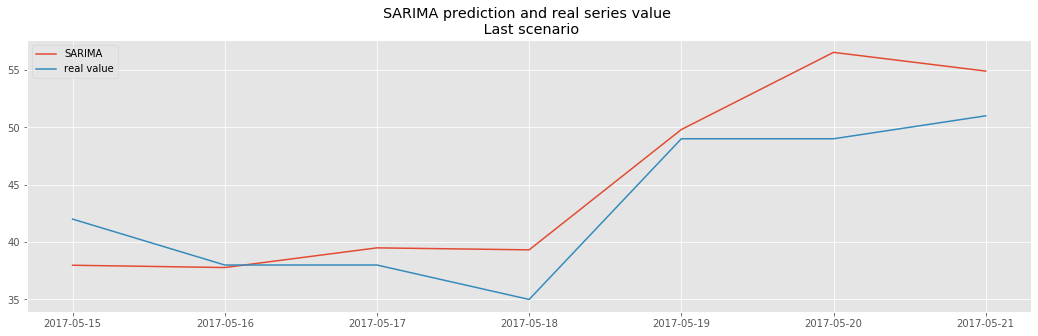

In [89]:
plt.plot(b_SARIMAX_pred)
plt.plot(cross_val_dict['cv'+str(number_of_validations)][1])
plt.legend(["SARIMA", "real value"])
plt.title("SARIMA prediction and real series value \n Last scenario")

And let's also plot our errors, compared with the rest of the methods:

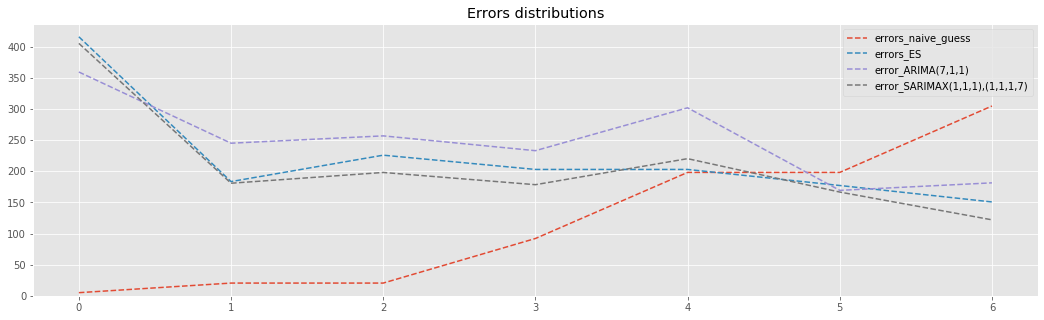

In [74]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_ES, '--')
ax.plot(b_mean_mse_series_ARIMA, '--')
ax.plot(b_mean_mse_series_SARIMAX, '--')

ax.set_ylim(bottom=0)

plt.legend(['errors_naive_guess','errors_ES','error_ARIMA(7,1,1)', 'error_SARIMAX(1,1,1),(1,1,1,7)'])
plt.title('Errors distributions');

In [75]:
mse_all_models["SARIMA"] = b_mean_mse_SARIMAX

### 2.2) PROPHET

We want now to compare the results of the classical methods used, against a time series tool developed by Facebook data scientists: Prophet.
    
*"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.*

*Prophet is open source software released by Facebook’s Core Data Science team."*

Source: https://facebook.github.io/prophet/

As in previous cases, we try it out with just the last series of those defined:

In [76]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE Prophet: 25.143556013502913


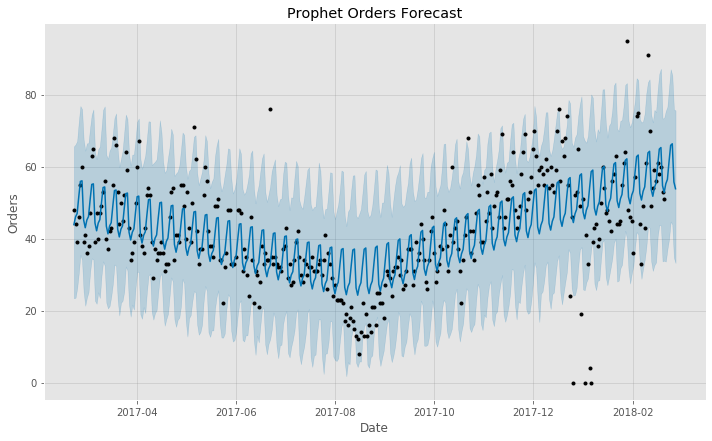

In [92]:
train_for_prophet = train.reset_index()
train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})

prophet_model = Prophet(interval_width=0.95)
prophet_model = prophet_model.fit(train_for_prophet)

prophet_series = prophet_model.make_future_dataframe(periods=7, freq='D')
prophet_prediction = prophet_model.predict(prophet_series)

# plt.figure(figsize=(18, 6))
prophet_model.plot(prophet_prediction, xlabel = 'Date', ylabel = 'Orders')
plt.title('Prophet Orders Forecast')

test_for_prophet = test.reset_index()
test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
predictions = prophet_model.predict(test_for_prophet)

mse_prophet = mean_squared_error(test_for_prophet["y"], predictions["yhat"])
print("MSE Prophet:", mse_prophet)

Now, we are ready to try it out, as the rest of our procesures, for all the values, so we can calculate an average value of its performance:

In [93]:
mean_mse_prophet = 0
mean_mse_series_prophet = np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]
    
    train_for_prophet = train.reset_index()
    train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})

    prophet_model = Prophet(interval_width=0.95, yearly_seasonality = True, weekly_seasonality = True)
    prophet_model = prophet_model.fit(train_for_prophet)

    test_for_prophet = test.reset_index()
    test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
    predictions = prophet_model.predict(test_for_prophet)

    squared_dif_series = (test_for_prophet["y"] - predictions["yhat"])**2

    mean_mse_prophet += (squared_dif_series).mean()   
    mean_mse_series_prophet += np.array(squared_dif_series)
    
    print("MSE:", (squared_dif_series).mean())

mean_mse_prophet = mean_mse_prophet/number_of_validations
mean_mse_series_prophet = pd.Series(mean_mse_series_prophet/horizon)

print("mean MSE:", mean_mse_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 28.31012492528287


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 76.29084192768792


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 44.10810916077868


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 34.651417140293184


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 18.920464011506148


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 42.882157213600955


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 86.8584349524543


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 84.01713753215462


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 19.263872813513462


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 36.29577775005119


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 28.57783239622507


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 18.950562415958398


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 112.43176180128408


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 314.3080342240979


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 33.86265263584375


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 70.32473217390906


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 54.495255017499474


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 62.52707434153626


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 10.565383159859369
MSE: 16.21917686813377
mean MSE: 59.693040123083506


As we can see, the Prophet models work out a nice, low error in the range of the best of our previous models: the SARIMA, indicating that the library is powerful enough for using it without any worries and yielding good forecasts, as their authors claim.

Let's plot the model predicted values for our last series and its errors, compared to those of the rest of our models:

Text(0.5, 1.0, 'SARIMA prediction and real series value \n Last scenario')

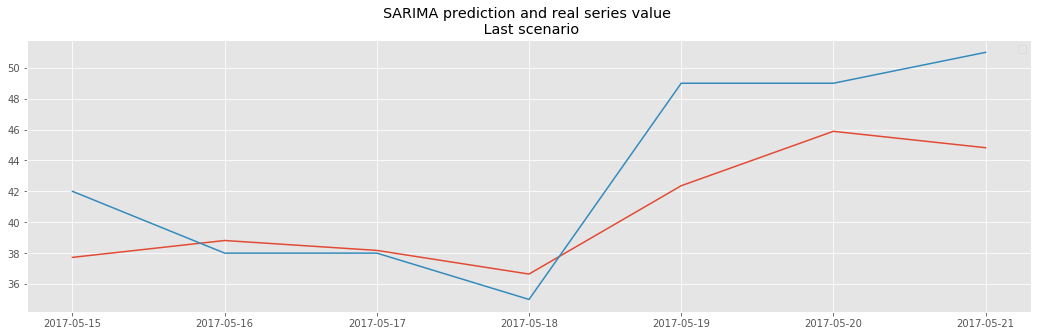

In [94]:
plt.plot(predictions['ds'],predictions["yhat"])
plt.plot(test)
plt.legend("SARIMA", "real value")
plt.title("SARIMA prediction and real series value \n Last scenario")

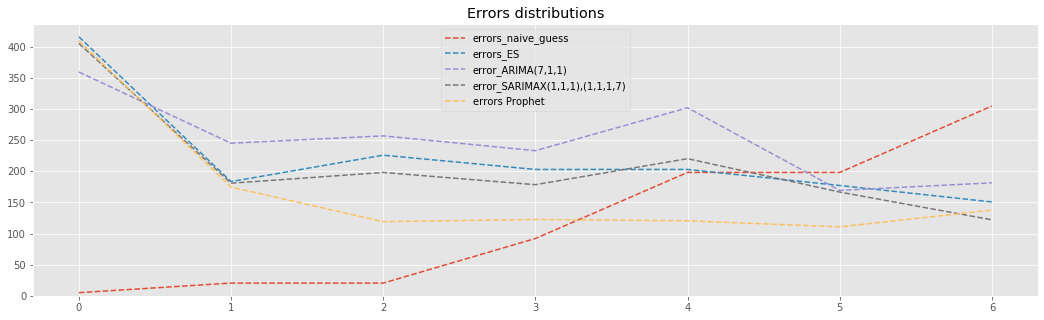

In [96]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_ES, '--')
ax.plot(b_mean_mse_series_ARIMA, '--')
ax.plot(b_mean_mse_series_SARIMAX, '--')
ax.plot(mean_mse_series_prophet, '--')

ax.set_ylim(bottom=0)

plt.legend(['errors_naive_guess','errors_ES','error_ARIMA(7,1,1)', 'error_SARIMAX(1,1,1),(1,1,1,7)', 'errors Prophet'])
plt.title('Errors distributions');

As it is shown above, Prophet keeps its error under control when compared with the rest of the models.

In [97]:
mse_all_models["Prophet"] = mean_mse_prophet

### 2.2) RANDOM FOREST

Lets now try rarandom forest with only the time series as input. The steps we will need to follow are:

1. Transform the data: each row should contain the features (previous days, matches, etc)
2. Fit the model with train
3. Predict with test
4. Evaluate the error.

Lets start creating the function that will transform the data, which was adapted from the following site: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

Our function takes in the series, the number of lags needed, and the number of steps ahead that we want to go for our prediction, and arranges the data in the series in a convenient manner to fit our purposes:

In [98]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

In [99]:
def data_transformation(series, n_lag, lead_time):
    """ Takes a series, a number of lag observations to use as input, 
    and a forecast lead time to predict, then will return a list of input/out 
    rows drawn from the series """

    data = list()
    # enumerate observations and create input/output patterns

    
    for i in range(n_lag, len(series)-max(lead_time)+1):
        
        end_ix=list()
        
        for lead in lead_time:
            ei = i + (lead - 1)
            end_ix.append(ei)
            
            # check if can create a pattern
            if ei >= len(series)-1:
                break
#         print(i, end_ix)
        
        # retrieve input and output
        start_ix = i - n_lag
        
        to_be_predicted = list()
        
        for element in end_ix:
            to_be_predicted.append(series[element])
        
        row = series[start_ix:i] + to_be_predicted
        data.append(row)
        
    return list(data)

In [100]:
aaa = ["a" + str(a) for a in range(20)]

In [101]:
data_transformation(aaa,7,[1,3,5,7])

[['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a9', 'a11', 'a13'],
 ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a10', 'a12', 'a14'],
 ['a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a11', 'a13', 'a15'],
 ['a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a12', 'a14', 'a16'],
 ['a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a13', 'a15', 'a17'],
 ['a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a14', 'a16', 'a18'],
 ['a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a15', 'a17', 'a19']]

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction, as well as the gap between the prediction and the data:

In [106]:
# Take into account the las 365 days
previous_days = 10

# Selecting the days to forecast
to_be_predicted = [1,2,3,4,5,6,7]

# Creating the column names for the dataframe
colnames_past = ['past' + str(previous_days - i) for i in range(previous_days)]
colnames_to_pred = ['to_pred' + str(i) for i in to_be_predicted]
# colnames_to_pred = ["to_pred"]

colnames = colnames_past  + colnames_to_pred

# Creating the slicer for the index of our dataframe
inf_index = max(to_be_predicted) + previous_days - 1

In [107]:
#Required by data_transformation
train_list = list(train)

test_n = train[len(train)-previous_days:].append(test)
test_list = list(test_n)

#Lets keep the index
index_train = train.index
index_test = test.index

#Transform test and train and keeps the 
train_rf = pd.DataFrame(data_transformation(train_list, previous_days, to_be_predicted), index = index_train[inf_index:], columns = colnames)
test_rf = pd.DataFrame(data_transformation(test_list, previous_days, to_be_predicted), columns = colnames)

In [108]:
test_rf

,past10,past9,past8,past7,past6,past5,past4,past3,past2,past1,to_pred1,to_pred2,to_pred3,to_pred4,to_pred5,to_pred6,to_pred7
0,70.0,49.0,54.0,59.0,56.0,61.0,58.0,60.0,53.0,51.0,57.0,55.0,56.0,59.0,59.0,50.0,51.0


In [110]:
RF_model_storage = list()

RandomFor_pred = np.array([0]*len(colnames_to_pred))
squared_error_distribution = np.array([0]*len(colnames_to_pred))

for i, column in enumerate(colnames_to_pred):

    # Create random forest object
    clf = RandomForestRegressor(max_depth=4)

    # Split the features form the target variable
    X_train = train_rf[colnames_past]
    y_train = train_rf[column]

    # Train the model
    RF_model = clf.fit(X_train,y_train)
    
    RF_model_storage.append(RF_model)

    X_test = test_rf[colnames_past]
    y_test = test_rf[column]

    # Making the prediction
    RF_pred = clf.predict(X_test)
    RandomFor_pred[i] = RF_pred

    # Calculate the error
    mse = mean_squared_error(RF_pred, y_test)
    squared_error_distribution[i] = mse

print(RandomFor_pred)
print(squared_error_distribution)

squared_error_distribution.mean()

[57 57 59 61 61 50 52]
[ 0  7 11  7  4  0  1]


4.285714285714286

Let's plot our results:

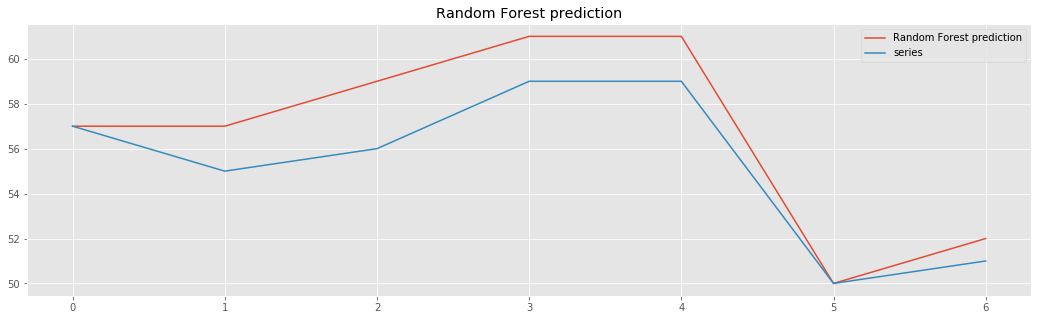

In [111]:
plt.plot(RandomFor_pred)
plt.plot(np.array(test))
plt.legend(["Random Forest prediction", "series"])
plt.title("Random Forest prediction");

Let's now define a function that does all the work for us:

In [115]:
def function_random_forest_models(train, test, previous_days, to_be_predicted):

    # Creating the column names for the dataframe
    colnames_past = ['past' + str(previous_days - i) for i in range(previous_days)]
    colnames_to_pred = ['to_pred' + str(i) for i in to_be_predicted]
    # colnames_to_pred = ["to_pred"]

    colnames = colnames_past  + colnames_to_pred

    # Creating the slicer for the index of our dataframe
    inf_index = max(to_be_predicted) + previous_days - 1

    #Required by data_transformation
    train_list = list(train)

    test_n = train[len(train)-previous_days:].append(test)
    test_list = list(test_n)

    #Lets keep the index
    index_train = train.index
    index_test = test.index

    #Transform test and train and keeps the 
    train_rf = pd.DataFrame(data_transformation(train_list, previous_days, to_be_predicted), index = index_train[inf_index:], columns = colnames)
    test_rf = pd.DataFrame(data_transformation(test_list, previous_days, to_be_predicted), columns = colnames)

    RF_model_storage = list()

    RandomFor_pred = np.array([0]*len(colnames_to_pred))
    squared_error_distribution = np.array([0]*len(colnames_to_pred))

    for i, column in enumerate(colnames_to_pred):

        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_rf[colnames_past]
        y_train = train_rf[column]

        # Train the model
        RF_model = clf.fit(X_train,y_train)

        RF_model_storage.append(RF_model)

        X_test = test_rf[colnames_past]
        y_test = test_rf[column]

        # Making the prediction
        RF_pred = clf.predict(X_test)
        RandomFor_pred[i] = RF_pred

        # Calculate the error
        mse = mean_squared_error(RF_pred, y_test)
        squared_error_distribution[i] = mse

    print("The MSE is:", squared_error_distribution.mean())
    
    return RandomFor_pred, squared_error_distribution, RF_model_storage 

We are going to try it out:

In [116]:
# Take into account the las 365 days
previous_days = 14

# Selecting the days to forecast
to_be_predicted = [1,2,3,4,5,6,7]

In [117]:
RF_pred, sqed, RF_model_storage = function_random_forest_models(train, test, previous_days, to_be_predicted)

The MSE is: 7.428571428571429


And, now, let's run the random forest for all our scenarios to get the mean value of its MSE

In [118]:
mean_mse_RF = 0
mean_mse_series_RF =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    RF_pred, squared_dif_series, RF_model_storage = function_random_forest_models(train, test, previous_days, to_be_predicted)
    
    mean_mse_RF += (squared_dif_series).mean()
    
    mean_mse_series_RF += np.array(squared_dif_series)

mean_mse_RF = mean_mse_RF/number_of_validations
mean_mse_series_RF = pd.Series(mean_mse_series_RF/horizon)

print("mean MSE:", mean_mse_RF)

The MSE is: 38.714285714285715
The MSE is: 3.2857142857142856
The MSE is: 110.0
The MSE is: 130.28571428571428
The MSE is: 132.57142857142858
The MSE is: 92.28571428571429
The MSE is: 73.42857142857143
The MSE is: 169.57142857142858
The MSE is: 7.857142857142857
The MSE is: 43.714285714285715
The MSE is: 189.0
The MSE is: 137.0
The MSE is: 152.71428571428572
The MSE is: 271.0
The MSE is: 55.285714285714285
The MSE is: 248.71428571428572
The MSE is: 62.42857142857143
The MSE is: 28.714285714285715
The MSE is: 5.0
The MSE is: 32.285714285714285
mean MSE: 99.19285714285715


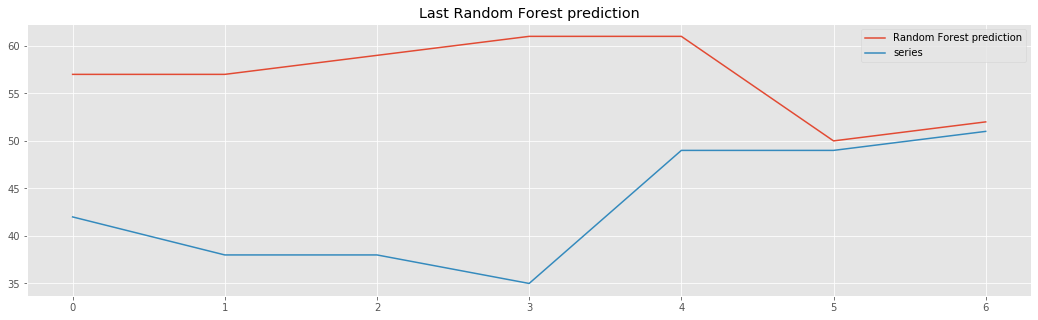

In [119]:
plt.plot(RandomFor_pred)
plt.plot(np.array(test))
plt.legend(["Random Forest prediction", "series"])
plt.title("Last Random Forest prediction");

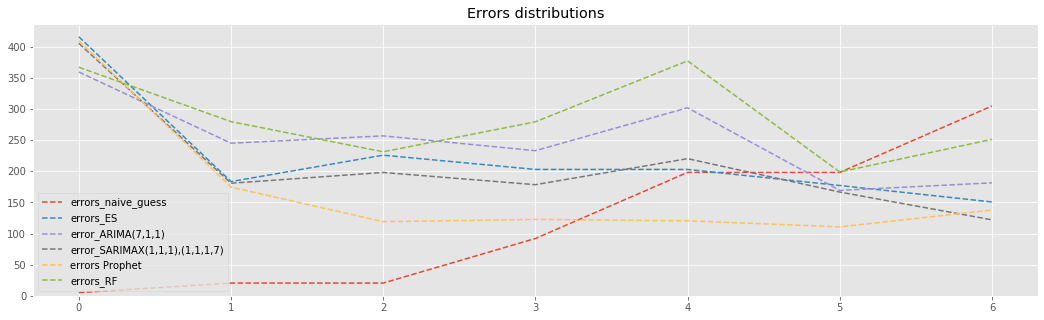

In [120]:
fig, ax =plt.subplots()

ax.plot(mean_mse_series_naive, '--')
ax.plot(mean_mse_series_ES, '--')
ax.plot(b_mean_mse_series_ARIMA, '--')
ax.plot(b_mean_mse_series_SARIMAX, '--')
ax.plot(mean_mse_series_prophet, '--')
ax.plot(mean_mse_series_RF, '--')

ax.set_ylim(bottom=0)

plt.legend(['errors_naive_guess','errors_ES','error_ARIMA(7,1,1)', 'error_SARIMAX(1,1,1),(1,1,1,7)', 'errors Prophet', 'errors_RF'])
plt.title('Errors distributions');

As we can see, for the naked model, using only information obtained from the series, the results are worse than those of the time series models.

Also, we can see that the errors of this method seem to be in the order of the time series methods for the first values (0, 1, 2), but spike at predictions 3, 4 and 5.

This phenomenom can be originated by the fact that, in this case, we are predicting each day with a different model.

As we now from the pacf, our series has small correlations with its 3rd and 4th lags:

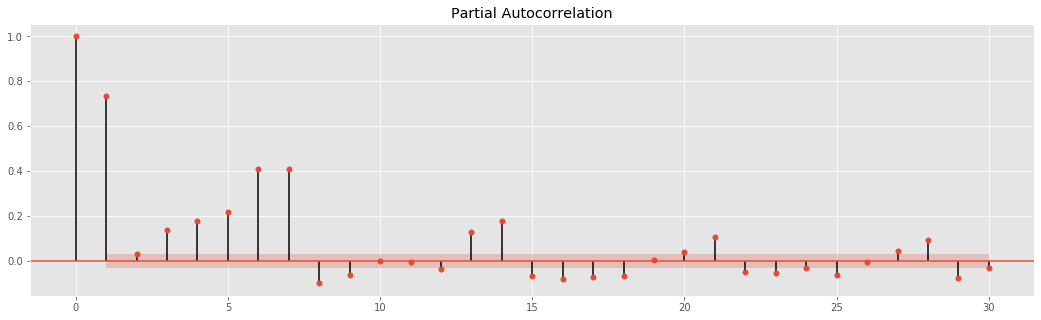

In [121]:
plot_pacf(series, lags = 30);

But, when predicting 4 days in advance using the random forest, we cannot use the value of the day before, nor any value until the 4th lag, so it is foreseeable that bigger errors will accumulate in the latter days of our predictions.

In [122]:
mse_all_models["Random Forest"] = mean_mse_RF

In [123]:
mse_all_models

{'general_mean': 225.7614637428625,
 'weekday_means': 165.98777936239694,
 'Naîve_guess': 95.82857142857142,
 'Holt-Winters': 77.91259311836548,
 'ARIMA': 87.30872242160628,
 'SARIMA': 73.54185340260217,
 'Prophet': 59.693040123083506,
 'Random Forest': 99.19285714285715}

### NOTES:

Improvements:
- One model per day of future prediction (so.. one model for n+1, one model for n+2, etc)
- Aggregate by week all data.
- Multivarient Random Forest
- https://www.r-bloggers.com/time-series-forecasting-with-random-forest/
- Retraining removing columns with 0

Transfer learning to other 